In [2]:
%matplotlib inline
%load_ext rpy2.ipython

In [3]:
%R require(ggplot2); require(GenometriCorr) ; require(rtracklayer);require( rtracklayer);\
require(IRanges)


/home/benjamin/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: ggplot2

  warnings.warn(x, RRuntimeWarning)
/home/benjamin/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: GenometriCorr

  warnings.warn(x, RRuntimeWarning)
/home/benjamin/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: IRanges

  warnings.warn(x, RRuntimeWarning)
/home/benjamin/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: BiocGenerics

  warnings.warn(x, RRuntimeWarning)
/home/benjamin/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x, RRuntimeWarning)
/home/benjamin/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching pack

array([1], dtype=int32)

In [4]:
import shutil, errno
from glob import glob as glb

def copyanything(src, dest_dir):
    for filename in glb(os.path.join(src, '*.*')):
        shutil.copy(filename, dest_dir)


In [5]:
def PDF(url):
    return HTML('<iframe src=./tmp_figures/%s width=700 height=350></iframe>' % url)

This notebook is aimed at getting all the effector candidates from the Pst_104E_genome as defined as the following.
EffectorP prediction done by Jana Sperschneider
Gene expression cluster analysis done by Jana Sperschneider picking cluster 2, 3 and 8

In [6]:
import os
from Bio import SeqIO
import pandas as pd
import re
from pybedtools import BedTool
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

In [7]:
#define your input folders
CLUSTER_FOLDER = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Pst_104E_genome/gene_expression/Pst104_p_SecretomeClustering'
EFFECTORP_FOLDER = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Pst_104E_genome/Secretomes/EffectorP'
GFF_FOLDER = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/032017_assembly'
PROTEIN_ANNO_FOLDER = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/enrichment_analysis/pa_26062017'
OUT_FOLDER = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/enrichment_analysis/lists'
OUT_FOLDER_FIG = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/enrichment_analysis/figures'
TMP_FIG_PATH = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/downstream_analysis_2017/scripts/tmp_figures'

In [8]:
if not os.path.exists(OUT_FOLDER_FIG):
    os.mkdir(OUT_FOLDER_FIG)

In [9]:
genome = 'Pst_104E_v12_'
p_effector_list = []
h_effector_list = []
p_effector_seq_list = []
h_effector_seq_list = []

In [10]:
#define what you want to take
clusters = [ 2, 3, 8]
clusters_files = [os.path.join(CLUSTER_FOLDER, x) for x in os.listdir(CLUSTER_FOLDER)\
                 if x.startswith('Cluster') and x.endswith('_DEs.fasta') and int(x[7]) in clusters ]
effectorp_files = [os.path.join(EFFECTORP_FOLDER, x) for x in os.listdir(EFFECTORP_FOLDER)\
                  if x.endswith('effectors.fasta') and x.startswith(genome)]

In [11]:
#get all the sequence names into a list from the fasta headers 
for file in clusters_files:
    fh = open(file, 'r')
    for seq in SeqIO.parse(fh, 'fasta'):
        if 'hcontig' in seq.id:
            h_effector_list.append(seq.id)
            h_effector_seq_list.append(seq)
        if 'pcontig' in seq.id:
            p_effector_list.append(seq.id)
            p_effector_seq_list.append(seq)
    fh.close()

for file in effectorp_files:
    fh = open(file, 'r')
    for seq in SeqIO.parse(fh, 'fasta'):
        if 'hcontig' in seq.id and seq.id not in h_effector_list:
            h_effector_list.append(seq.id)
            h_effector_seq_list.append(seq)
        if 'pcontig' in seq.id and seq.id not in p_effector_list:
            p_effector_list.append(seq.id)
            p_effector_seq_list.append(seq)
    fh.close()

In [12]:
p_effector_file = os.path.join(OUT_FOLDER, genome + 'p_effector.list')
h_effector_file = os.path.join(OUT_FOLDER, genome + 'h_effector.list')

In [13]:
#write out the sets of effector candidates
fh = open(p_effector_file, 'w')
for ec in set(p_effector_list):
    print(ec, file=fh)
fh.close()
fh = open(h_effector_file, 'w')
for ec in set(h_effector_list):
    print(ec, file=fh)
fh.close()
#write out effector fasta files
SeqIO.write(p_effector_seq_list, open(p_effector_file.replace('.list', '.protein.fasta'), 'w'), 'fasta')
SeqIO.write(h_effector_seq_list, open(h_effector_file.replace('.list', '.protein.fasta'), 'w'), 'fasta')

972

In [14]:
#subset the gff files as well and write those out
p_gff_file = [os.path.join(GFF_FOLDER, x) for x in os.listdir(GFF_FOLDER)\
                 if x.startswith(genome+'p_ctg') and x.endswith('anno.gff3') ][0]
h_gff_file = [os.path.join(GFF_FOLDER, x) for x in os.listdir(GFF_FOLDER)\
                 if x.startswith(genome+'h_ctg') and x.endswith('anno.gff3') ][0]

In [15]:
os.listdir(GFF_FOLDER)

['Pst_104E_v12_p_ctg.anno.protein.fa',
 'Pst_104E_v12_ph_ctg.anno.CDS.fa',
 'pcontig_smaller_2000.txt',
 'Pst_104E_v12_h_ctg.anno.gff3',
 'Pst_104E_v12_ph_ctg.fa.fai',
 'Pst_104E_v12_h_ctg.fa.fai',
 'Pst_104E_v12_p_ctg.anno.gene.fa',
 'hcontig_greater_2000.txt',
 'Pst_104E_v12_h_ctg.genome_file',
 'Pst_104E_v12_h_ctg.anno.gene.fa',
 'Pst_104E_v12_p_ctg.genome_file',
 'Pst_104E_v12_h_ctg.anno.CDS.fa',
 'Pst_104E_v12_ph_ctg.anno.CDS.gff3',
 'pcontig_greater_2000.txt',
 'Pst_104E_v12_ph_ctg.anno.protein.fa',
 'Pst_104E_v12_p_ctg.fa',
 'Pst_104E_v12_p_ctg.anno.gff3',
 'Pst_104E_v12_ph_ctg.fa',
 'Pst_104E_v12_ph_ctg.REPET.gff',
 'Pst_104E_v12_h_ctg.anno.protein.fa',
 'README.txt',
 'Pst_104E_v12_h_ctg.fa',
 'Pst_104E_v12_p_ctg.anno.CDS.fa',
 'Pst_104E_v12_p_ctg.REPET.gff',
 'hcontig_smaller_2000.txt',
 'Pst_104E_v12_p_ctg.anno.CDS.gff3',
 'Pst_104E_v12_h_ctg.anno.CDS.gff3',
 'Pst_104E_v12_p_ctg.fa.fai',
 'Pst_104E_v12_h_ctg.REPET.gff',
 'Pst_104E_v12_ph_ctg.anno.gff3']

In [16]:
#get repeat gff files
p_repeat_gff_fn = [os.path.join(GFF_FOLDER, x) for x in os.listdir(GFF_FOLDER)\
                 if x.startswith(genome+'p_ctg') and x.endswith('REPET.gff') ][0]
h_repeat_gff_fn  = [os.path.join(GFF_FOLDER, x) for x in os.listdir(GFF_FOLDER)\
                 if x.startswith(genome+'h_ctg') and x.endswith('REPET.gff') ][0]

In the command line in /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/TE_analysis the superfamily gff files were sorted as followed and copied over into the lists folder
sort Pst_104E_v12_h_ctg.REPET.superfamily.gff -k1,1n -k4,4n > Pst_104E_v12_h_ctg.REPET.sorted.superfamily.gff

In [17]:
#get repeat gff files
p_repeat_superfamily_gff_fn = [os.path.join(OUT_FOLDER, x) for x in os.listdir(OUT_FOLDER)\
                 if x.startswith(genome+'p_ctg') and x.endswith('REPET.sorted.superfamily.gff') ][0]
h_repeat_superfamily_gff_fn  = [os.path.join(OUT_FOLDER, x) for x in os.listdir(OUT_FOLDER)\
                 if x.startswith(genome+'h_ctg') and x.endswith('REPET.sorted.superfamily.gff') ][0]

In [18]:
#gff header 
gff_header = ['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes']

In [19]:
#now subset the gff files for effectors only
p_gff_df = pd.read_csv(p_gff_file, header = None, sep='\t', names= gff_header)
p_gff_df['ID'] = p_gff_df.attributes.str.extract(r'ID=([^;]*);', expand=False)
p_gff_df.sort_values(by=['seqid', 'start'], inplace = True)
h_gff_df = pd.read_csv(h_gff_file, header = None, sep='\t', names= gff_header)
h_gff_df['ID'] = h_gff_df.attributes.str.extract(r'ID=([^;]*);', expand=False)
h_gff_df.sort_values(by=['seqid', 'start'], inplace = True)

In [20]:
#now sort REPET gff and write out again
p_repeat_gff_df = pd.read_csv(p_repeat_gff_fn, header=None, sep='\t', names=gff_header, comment='#')
p_repeat_gff_fn = os.path.join(OUT_FOLDER,p_repeat_gff_fn.split('/')[-1] )
p_repeat_gff_df.sort_values(by=['seqid', 'start']).to_csv(p_repeat_gff_fn, header=None, index=None, sep='\t')
h_repeat_gff_df = pd.read_csv(h_repeat_gff_fn, header=None, sep='\t', names=gff_header, comment='#')
h_repeat_gff_fn = os.path.join(OUT_FOLDER,h_repeat_gff_fn.split('/')[-1] )
h_repeat_gff_df.sort_values(by=['seqid', 'start']).to_csv(h_repeat_gff_fn, header=None, index=None, sep='\t')

In [21]:
#now write out dataframes for p_gff

#bed 6 file
p_effector_bed_fn = p_effector_file.replace('.list', '.gene.bed')
p_gff_df[(p_gff_df.type == 'gene') & (p_gff_df.ID.str.replace('TU', 'model').isin(p_effector_list))].\
    loc[:,['seqid', 'start', 'end', 'ID', 'score', 'strand']].to_csv(p_effector_bed_fn, header=None, index=None, sep='\t')
    
p_effector_gff_fn = p_effector_file.replace('.list', '.gene.gff3')    
p_gff_df[(p_gff_df.type == 'gene') & (p_gff_df.ID.str.replace('TU', 'model').isin(p_effector_list))].\
    loc[:,gff_header].to_csv(p_effector_gff_fn, header=None, index=None, sep='\t')


#bed 6 file no effectors
p_noeffector_bed_fn = p_effector_file.replace('.list', 'p_noeffector.gene.bed')
p_gff_df[(p_gff_df.type == 'gene') & (~p_gff_df.ID.str.replace('TU', 'model').isin(p_effector_list))].\
    loc[:,['seqid', 'start', 'end', 'ID', 'score', 'strand']].to_csv(p_noeffector_bed_fn, header=None, index=None, sep='\t')

#no effector gff and list
p_noeffector_gff_fn = p_effector_file.replace('p_effector.list', 'p_noeffector.gene.gff3')    
p_gff_df[(p_gff_df.type == 'gene') & (~p_gff_df.ID.str.replace('TU', 'model').isin(p_effector_list))].\
    loc[:,gff_header].to_csv(p_noeffector_gff_fn, header=None, index=None, sep='\t')

file_name = p_effector_file.replace('p_effector.list', 'p_noeffector.list')
p_gff_df[(p_gff_df.type == 'gene') & (~p_gff_df.ID.str.replace('TU', 'model').isin(p_effector_list))]['ID'].str.replace('TU', 'model')\
    .to_csv(file_name, header=None, index=None, sep='\t')

In [22]:
#now write out dataframes for h_gff
h_effector_gff_fn = h_effector_file.replace('.list', '.gene.gff3')
h_gff_df[(h_gff_df.type == 'gene') & (h_gff_df.ID.str.replace('TU', 'model').isin(h_effector_list))].\
    loc[:,gff_header].to_csv(h_effector_gff_fn, header=None, index=None, sep='\t')
    
#no effector list
h_noeffector_gff_fn = h_effector_file.replace('h_effector.list', 'h_noeffector.gene.gff3')    
h_gff_df[(h_gff_df.type == 'gene') & (~h_gff_df.ID.str.replace('TU', 'model').isin(h_effector_list))].\
    loc[:,gff_header].to_csv(h_noeffector_gff_fn, header=None, index=None, sep='\t')
file_name = h_effector_file.replace('h_effector.list', 'h_noeffector.list')
h_gff_df[(h_gff_df.type == 'gene') & (~h_gff_df.ID.str.replace('TU', 'model').isin(h_effector_list))]['ID'].str.replace('TU', 'model')\
    .to_csv(file_name, header=None, index=None, sep='\t')

In [23]:
#now get BUSCO list and write out stuff
p_busco_file = [os.path.join(PROTEIN_ANNO_FOLDER, x) for x in os.listdir(PROTEIN_ANNO_FOLDER) if x.startswith(genome+'p_ctg') and 'busco' in x][0]
p_busco_list = pd.read_csv(p_busco_file, header=None, sep='\t')[0].tolist()
h_busco_file = [os.path.join(PROTEIN_ANNO_FOLDER, x) for x in os.listdir(PROTEIN_ANNO_FOLDER) if x.startswith(genome+'h_ctg') and 'busco' in x][0]
h_busco_list = pd.read_csv(h_busco_file, header=None, sep='\t')[0].tolist()

In [24]:
#write out BUSCO for pcontigs
file_name = p_effector_file.replace('effector.list', 'busco.list')
p_gff_df[(p_gff_df.type == 'gene') & (p_gff_df.ID.str.replace('TU', 'model').isin(p_busco_list))]['ID'].str.replace('TU', 'model')\
    .to_csv(file_name, header=None, index=None, sep='\t')
p_busco_gff_fn = p_effector_file.replace('effector.list', 'busco.gene.gff3')
p_gff_df[(p_gff_df.type == 'gene') & (p_gff_df.ID.str.replace('TU', 'model').isin(p_busco_list))].\
    loc[:,gff_header].to_csv(p_busco_gff_fn, header=None, index=None, sep='\t')

p_busco_bed_fn = p_effector_file.replace('effector.list', 'busco.gene.bed')
p_gff_df[(p_gff_df.type == 'gene') & (p_gff_df.ID.str.replace('TU', 'model').isin(p_busco_list))].\
    loc[:,['seqid', 'start', 'end', 'ID', 'score', 'strand']].to_csv(p_busco_bed_fn, header=None, index=None, sep='\t')

In [25]:
#write out non BUSCO for pcontigs
file_name = p_effector_file.replace('effector.list', 'non_busco.list')
p_gff_df[(p_gff_df.type == 'gene') & (~p_gff_df.ID.str.replace('TU', 'model').isin(p_busco_list))]['ID'].str.replace('TU', 'model')\
    .to_csv(file_name, header=None, index=None, sep='\t')
p_non_busco_gff_fn = p_effector_file.replace('effector.list', 'non_busco.gene.gff3')
p_gff_df[(p_gff_df.type == 'gene') & (~p_gff_df.ID.str.replace('TU', 'model').isin(p_busco_list))].\
    loc[:,gff_header].to_csv(p_non_busco_gff_fn, header=None, index=None, sep='\t')

p_non_busco_bed_fn = p_effector_file.replace('effector.list', 'non_busco.gene.bed')
p_gff_df[(p_gff_df.type == 'gene') & (~p_gff_df.ID.str.replace('TU', 'model').isin(p_busco_list))].\
    loc[:,['seqid', 'start', 'end', 'ID', 'score', 'strand']].to_csv(p_non_busco_bed_fn, header=None, index=None, sep='\t')

In [144]:
#write out no busco no effector bed files
p_noeffector_nobusco_bed_fn = p_effector_file.replace('effector.list', 'no_busco_no_effector.gene.bed')    

p_gff_df[(p_gff_df.type == 'gene') & (~p_gff_df.ID.str.replace('TU', 'model').isin(p_busco_list))\
       &(~p_gff_df.ID.str.replace('TU', 'model').isin(p_effector_list))].\
    loc[:,['seqid', 'start', 'end', 'ID', 'score', 'strand']].to_csv(p_noeffector_nobusco_bed_fn, header=None, index=None, sep='\t')



In [27]:
#write out BUSCO for hcontigs
file_name = h_effector_file.replace('effector.list', 'busco.list')
h_gff_df[(h_gff_df.type == 'gene') & (h_gff_df.ID.str.replace('TU', 'model').isin(h_busco_list))]['ID'].str.replace('TU', 'model')\
    .to_csv(file_name, header=None, index=None, sep='\t')
h_busco_gff_fn = h_effector_file.replace('effector.list', 'busco.gene.gff3')
h_gff_df[(h_gff_df.type == 'gene') & (h_gff_df.ID.str.replace('TU', 'model').isin(h_busco_list))].\
    loc[:,gff_header].to_csv(h_busco_gff_fn, header=None, index=None, sep='\t')

In [28]:
#write all genes
h_gene_gff_fn = h_effector_file.replace('effector.list', 'all.gene.gff3')
h_gff_df[(h_gff_df.type == 'gene') ].\
    loc[:,gff_header].to_csv(h_gene_gff_fn, header=None, index=None, sep='\t')
p_gene_gff_fn = p_effector_file.replace('effector.list', 'all.gene.gff3')
p_gff_df[(p_gff_df.type == 'gene') ].\
    loc[:,gff_header].to_csv(p_gene_gff_fn, header=None, index=None, sep='\t')
#write bed 6
p_gene_bed_fn = p_effector_file.replace('effector.list', 'all.gene.bed')
p_gff_df[(p_gff_df.type == 'gene') ].\
    loc[:,['seqid', 'start', 'end', 'ID', 'score', 'strand']].to_csv(p_gene_bed_fn, header=None, index=None, sep='\t')

In [29]:
#get the distances

#read in files and generate bedtool objects. Issue might be that same variable are used for the bed files
#while those are sometimes gff and sometimes bed. Needs changing
p_effector_bed = BedTool(p_effector_gff_fn)
p_noeffector_bed = BedTool(p_noeffector_gff_fn)
p_busco_bed = BedTool(p_busco_gff_fn)
p_repeats_bed = BedTool(p_repeat_superfamily_gff_fn)
p_non_busco_bed = BedTool(p_non_busco_bed_fn)


#get closest repeat and make a df out of it
p_closest_rep_to_eff = p_effector_bed.closest(p_repeats_bed, d=True)
p_closest_rep_to_eff_df = p_closest_rep_to_eff.to_dataframe()

#here subset the repeat superfamily GFF to filder out smaller repeats if wanted
tmp_REPET = pd.read_csv(p_repeat_superfamily_gff_fn, header=None, sep='\t', names=gff_header)
tmp_REPET['distance'] = tmp_REPET.end - tmp_REPET.start
tmp_fn = p_repeat_superfamily_gff_fn.replace('superfamily', 'tmpsuperfamily')
tmp_REPET[tmp_REPET.distance > 400].loc[:,gff_header].to_csv(tmp_fn, header=None, sep='\t', index=None)

#read this in as repeat_df
p_repeats_bed = BedTool(tmp_fn)

/home/benjamin/anaconda3/lib/python3.5/site-packages/pybedtools/bedtool.py:3199: UserWarning: Default names for filetype gff are:
['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attributes']
but file has 19 fields; you can supply custom names with the `names` kwarg
  % (self.file_type, _names, self.field_count()))


In [30]:
#bed closest header when using gff as input files
bed_repeat_closest_header = [x +'_gene' for x in gff_header] + [x +'_repeat' for x in gff_header] + ['distance']

In [31]:
import warnings
warnings.filterwarnings('ignore')

Effectors closest Repeat
                 18
count   1574.000000
mean    2948.394536
std     4173.885557
min        0.000000
25%      358.250000
50%     1243.000000
75%     4062.500000
max    42804.000000


(0, 10000)

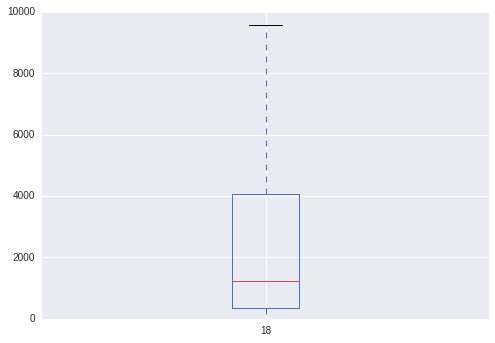

In [32]:
print('Effectors closest Repeat')
print(p_effector_bed.closest(p_repeats_bed,d=True,t='last').to_dataframe().iloc[:,18:20].describe())
p_effector_bed.closest(p_repeats_bed, d=True, t='last').to_dataframe().boxplot(column=18)
plt.ylim(0, 10000)

Repeat closest effector
                  18
count   40544.000000
mean    46098.857735
std     48802.670719
min         0.000000
25%     12473.750000
50%     29779.500000
75%     62678.250000
max    350531.000000


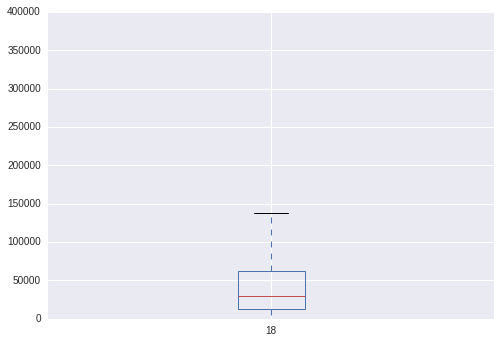

In [33]:
print('Repeat closest effector')
print(p_repeats_bed.closest(p_effector_bed,d=True,t='last').to_dataframe().iloc[:,18:20].describe())
p_repeats_bed.closest(p_effector_bed, d=True, t='last').to_dataframe().boxplot(column=18)


BUSCO distance to closest repeat
                 18
count   1444.000000
mean    2938.963989
std     4085.483570
min        0.000000
25%      452.500000
50%     1321.000000
75%     3907.250000
max    41225.000000


(0, 10000)

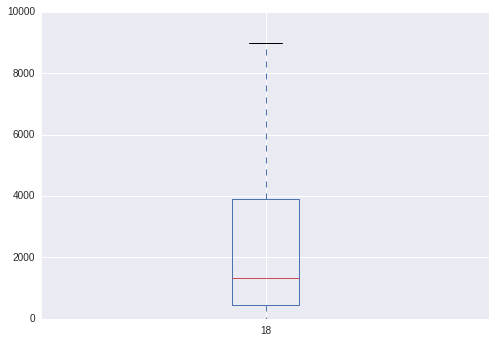

In [34]:
print('BUSCO distance to closest repeat')
print(p_busco_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().iloc[:,18:20].describe())
p_busco_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().boxplot(column=18)
plt.ylim(0, 10000)

BUSCO distance to closest repeat
                  18
count   29483.000000
mean    42894.173829
std     48094.906810
min         0.000000
25%     10795.000000
50%     26583.000000
75%     55637.500000
max    330582.000000


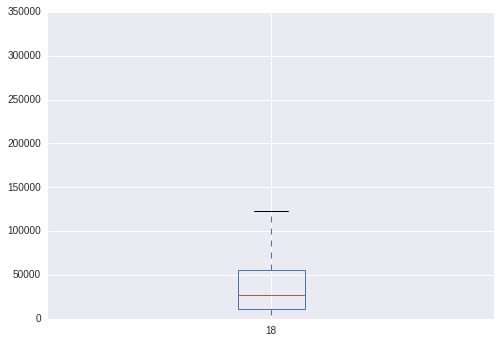

In [35]:
print('BUSCO distance to closest repeat')
print(p_repeats_bed.closest(p_busco_bed, d=True,t='last').to_dataframe().iloc[:,18:20].describe())
p_repeats_bed.closest(p_busco_bed, d=True,t='last').to_dataframe().boxplot(column=18)


No Effector distance to closest repeat
                 18
count  14296.000000
mean    2223.728316
std     3714.836857
min        0.000000
25%        0.000000
50%      740.000000
75%     2885.500000
max    55526.000000


(0, 10000)

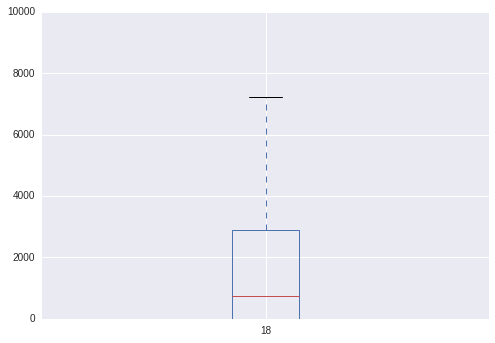

In [36]:
print('No Effector distance to closest repeat')
print(p_noeffector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().iloc[:,18:20].describe())
p_noeffector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().boxplot(column=18)
plt.ylim(0, 10000)

Relative distance from TE elements to other elements


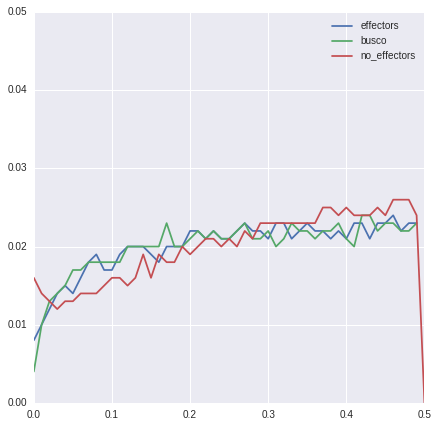

In [37]:
print('Relative distance from TE elements to other elements')
fig, ax = plt.subplots(figsize=(7,7))
plt.plot(p_repeats_bed.reldist(p_effector_bed)['reldist'], p_repeats_bed.reldist(p_effector_bed)['fraction'], label ='effectors')
plt.plot(p_repeats_bed.reldist(p_busco_bed)['reldist'], p_repeats_bed.reldist(p_busco_bed)['fraction'], label= 'busco')
plt.plot(p_repeats_bed.reldist(p_noeffector_bed)['reldist'], p_repeats_bed.reldist(p_noeffector_bed)['fraction'], label='no_effectors')
plt.ylim(0, 0.05)
plt.legend()

Relative distance of other elements to TEs


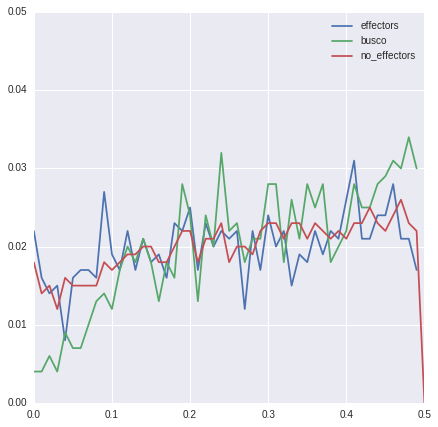

In [38]:
print('Relative distance of other elements to TEs')
fig, ax = plt.subplots(figsize=(7,7))
plt.plot(p_effector_bed.reldist(p_repeats_bed)['reldist'], p_effector_bed.reldist(p_repeats_bed)['fraction'], label ='effectors')
plt.plot(p_busco_bed.reldist(p_repeats_bed)['reldist'], p_busco_bed.reldist(p_repeats_bed)['fraction'], label= 'busco')
plt.plot(p_noeffector_bed.reldist(p_repeats_bed)['reldist'], p_noeffector_bed.reldist(p_repeats_bed)['fraction'], label='no_effectors')
plt.ylim(0, 0.05)
plt.legend()

In [39]:
#some stuff in the following lines

In [40]:
p_noeffector_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().groupby(17).count()[0].sort_values().tail(10)/len(p_noeffector_bed)*100

17
ClassII:MITE:?                3.539083
ClassI:LTR:?                  3.915285
ClassII:TIR:PIF-Harbinger     4.563188
ClassII:TIR:Tc1-Mariner       4.807022
ClassII:TIR:hAT               8.415773
ClassI:LARD:?                 8.764108
ClassI:LTR:Copia              9.342344
ClassII:TIR:?                 9.899680
ClassII:?:?                  12.644559
ClassI:LTR:Gypsy             18.266685
Name: 0, dtype: float64

In [41]:
p_effector_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().groupby(17).count()[0].sort_values().tail(10)/len(p_effector_bed)*100

17
ClassII:TIR:PIF-Harbinger     3.240152
ClassII:TIR:Tc1-Mariner       3.621347
ClassI:LTR:?                  4.447268
ClassII:MITE:?                5.146125
ClassI:LTR:Copia              8.831004
ClassII:TIR:hAT               9.085133
ClassII:TIR:?                10.101652
ClassI:LARD:?                10.864041
ClassI:LTR:Gypsy             14.104193
ClassII:?:?                  17.217281
Name: 0, dtype: float64

In [42]:
p_busco_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().groupby(17).count()[0].sort_values().tail(10)/len(p_busco_bed)*100

17
ClassI:LTR:?                  4.362881
ClassII:TIR:PIF-Harbinger     4.432133
ClassII:TIR:Tc1-Mariner       5.401662
ClassII:MITE:?                5.747922
ClassI:LTR:Copia              7.963989
ClassII:TIR:hAT               8.518006
ClassI:LARD:?                10.526316
ClassII:TIR:?                12.119114
ClassI:LTR:Gypsy             13.573407
ClassII:?:?                  15.858726
Name: 0, dtype: float64

In [43]:
p_busco_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().groupby(17).mean()[18].sort_values().tail(10)

17
ClassII:TIR:hAT             3189.162393
ClassII:?:Sola              3290.000000
ClassI:LTR:Gypsy            3528.756906
ClassII:TIR:Tc1-Mariner     3675.421053
ClassII:Helitron:?          3765.230769
ClassI:LINE:Jockey          3832.500000
ClassII:TIR:MuDR            3947.156250
ClassII:Maverick:?          4384.285714
ClassI:LTR:ERV              7696.000000
ClassII:?:Academ           10287.000000
Name: 18, dtype: float64

In [44]:
p_noeffector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().groupby(17).mean()[18].sort_values().tail(10)

17
noCat                       2523.402899
ClassII:TIR:hAT             2570.000864
ClassII:TIR:MuDR            2596.115207
ClassII:TIR:?               2741.221992
ClassII:TIR:Tc1-Mariner     2775.314675
ClassII:Helitron:?          2827.692308
ClassI:LINE:Jockey          3003.733333
ClassII:MITE:?              3250.652273
ClassI:LTR:ERV             10918.400000
ClassII:T                           NaN
Name: 18, dtype: float64

In [45]:
p_effector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().groupby(17).mean()[18].sort_values().tail(10)

17
ClassI:LTR:Gypsy           3231.149038
ClassII:MITE:?             3260.383562
ClassII:TIR:?              3320.779874
ClassI:LTR:Copia           3353.064516
ClassII:TIR:hAT            3695.187050
noCat                      3752.581395
ClassI:TRIM:?              3884.500000
ClassII:TIR:Tc1-Mariner    3908.293103
ClassII:Helitron:?         3995.631579
ClassII:TIR:CACTA          6750.200000
Name: 18, dtype: float64

In [46]:
#now lookine at ClassII:?:? specifically
tmp_REPET[(tmp_REPET.distance > 400)&(tmp_REPET.attributes == 'ClassII:?:?')].loc[:,gff_header].to_csv(tmp_fn, header=None, sep='\t', index=None)
p_repeats_bed = BedTool(tmp_fn)

Effectors and there closest ClassII:?:? elements
                  18
count    1478.000000
mean    17295.579838
std     18552.884167
min         6.000000
25%      4564.250000
50%     11582.000000
75%     24324.000000
max    194780.000000


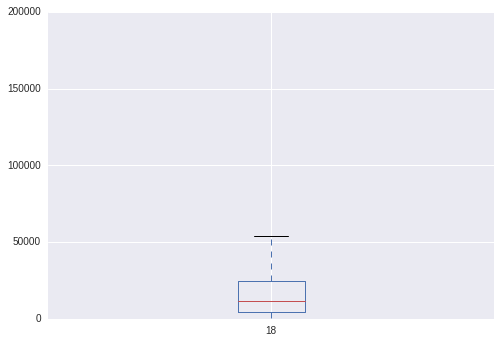

In [47]:
print('Effectors and there closest ClassII:?:? elements')
print(p_effector_bed.closest(p_repeats_bed,d=True,t='last', io=True).to_dataframe().iloc[:,18:20].describe())
p_effector_bed.closest(p_repeats_bed, d=True, t='last', io=True).to_dataframe().boxplot(column=18)

ClassII:?:? elements and there closest Effectors 
                  18
count    3496.000000
mean    39160.882151
std     43981.650192
min         6.000000
25%      9340.000000
50%     24500.500000
75%     51721.000000
max    327768.000000


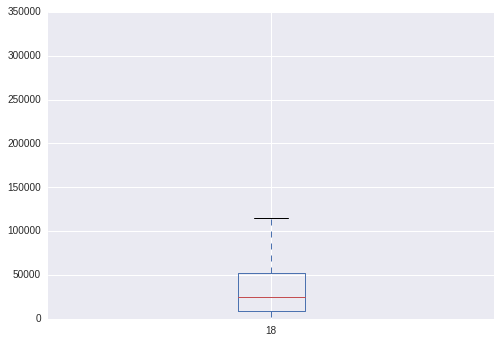

In [48]:
print('ClassII:?:? elements and there closest Effectors ')
print(p_repeats_bed.closest(p_effector_bed, d=True, t='last', io=True).to_dataframe().iloc[:,18:20].describe())
p_repeats_bed.closest(p_effector_bed, d=True, t='last', io=True).to_dataframe().boxplot(column=18)

Relative distance from ClassII:?:? elements and other elements


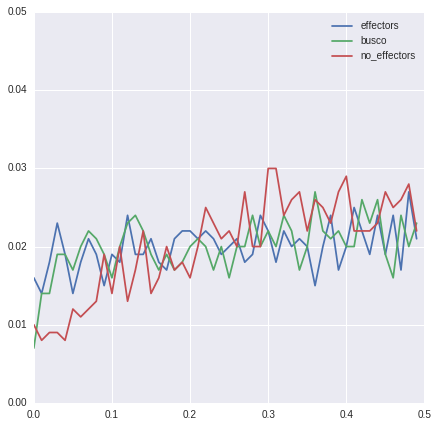

In [49]:
print('Relative distance from ClassII:?:? elements and other elements')
fig, ax = plt.subplots(figsize=(7,7))
plt.plot(p_repeats_bed.reldist(p_effector_bed)['reldist'], p_repeats_bed.reldist(p_effector_bed)['fraction'], label ='effectors')
plt.plot(p_repeats_bed.reldist(p_busco_bed)['reldist'], p_repeats_bed.reldist(p_busco_bed)['fraction'], label= 'busco')
plt.plot(p_repeats_bed.reldist(p_noeffector_bed)['reldist'], p_repeats_bed.reldist(p_noeffector_bed)['fraction'], label='no_effectors')
plt.ylim(0, 0.05)
plt.legend()

Relative distance of other elements to ClassII:?:?


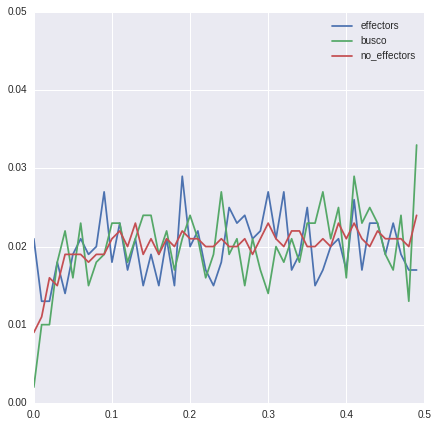

In [50]:
print('Relative distance of other elements to ClassII:?:?')
fig, ax = plt.subplots(figsize=(7,7))
plt.plot(p_effector_bed.reldist(p_repeats_bed)['reldist'], p_effector_bed.reldist(p_repeats_bed)['fraction'], label ='effectors')
plt.plot(p_busco_bed.reldist(p_repeats_bed)['reldist'], p_busco_bed.reldist(p_repeats_bed)['fraction'], label= 'busco')
plt.plot(p_noeffector_bed.reldist(p_repeats_bed)['reldist'], p_noeffector_bed.reldist(p_repeats_bed)['fraction'], label='no_effectors')
plt.ylim(0, 0.05)
plt.legend()

BUSCOs distance to closest ClassII:?:?
                  18
count    1296.000000
mean    17249.780093
std     19339.281875
min         2.000000
25%      4185.000000
50%     11023.000000
75%     23301.250000
max    156673.000000


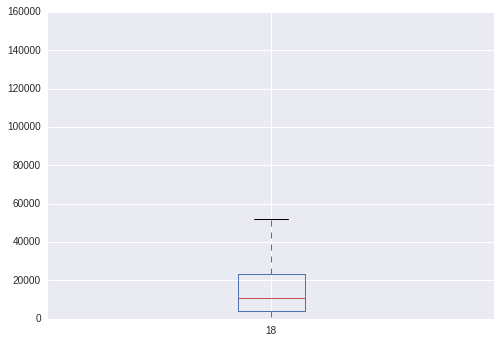

In [51]:
print('BUSCOs distance to closest ClassII:?:?')
print(p_busco_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().iloc[:,18:20].describe())
p_busco_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().boxplot(column=18)

No effectors distance to closest ClassII:?:?
                  18
count    5302.000000
mean    15810.004715
std     17908.874295
min         2.000000
25%      4179.250000
50%     10144.500000
75%     21210.500000
max    187286.000000


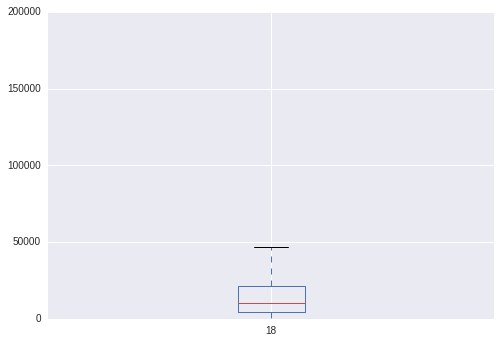

In [52]:
print('No effectors distance to closest ClassII:?:?')
print(p_noeffector_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().iloc[:,18:20].describe())
p_noeffector_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().boxplot(column=18)

No effectors distance to closest ClassII:?:? while allowing for overlaps
                  18
count   13770.000000
mean    17439.554539
std     20919.950567
min         0.000000
25%      4022.250000
50%     10798.500000
75%     23023.500000
max    190204.000000


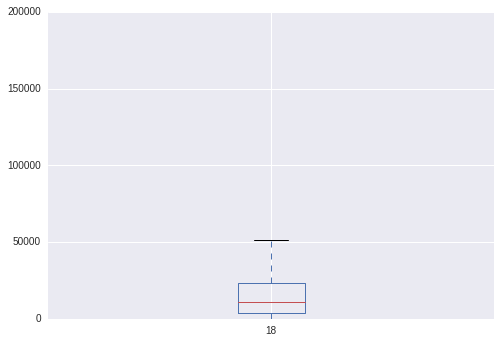

In [53]:
print('No effectors distance to closest ClassII:?:? while allowing for overlaps')
print(p_noeffector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().iloc[:,18:20].describe())
p_noeffector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().boxplot(column=18)

Relative distance of between BUSCOS and effectors


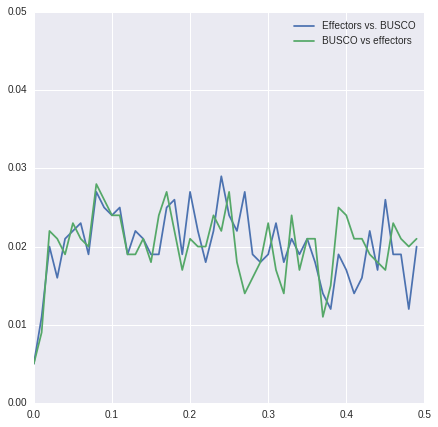

In [54]:
#look at if effectors and buscos are linked or further apart using the redist function
print('Relative distance of between BUSCOS and effectors')
fig, ax = plt.subplots(figsize=(7,7))
plt.plot(p_effector_bed.reldist(p_busco_bed)['reldist'], p_effector_bed.reldist(p_busco_bed)['fraction'], label ='Effectors vs. BUSCO')
plt.plot(p_busco_bed.reldist(p_effector_bed)['reldist'], p_busco_bed.reldist(p_effector_bed)['fraction'], label= 'BUSCO vs effectors')

plt.ylim(0, 0.05)
plt.legend()

Relative distance of between non-effectors and effectors


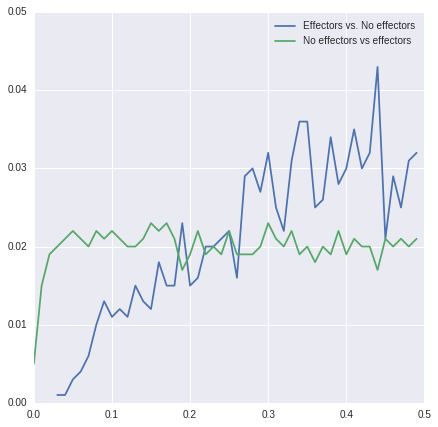

In [55]:
print('Relative distance of between non-effectors and effectors')
fig, ax = plt.subplots(figsize=(7,7))
plt.plot(p_effector_bed.reldist(p_noeffector_bed)['reldist'], p_effector_bed.reldist(p_noeffector_bed)['fraction'], label ='Effectors vs. No effectors')
plt.plot(p_noeffector_bed.reldist(p_effector_bed)['reldist'], p_noeffector_bed.reldist(p_effector_bed)['fraction'], label= 'No effectors vs effectors')

plt.ylim(0, 0.05)
plt.legend()

Relative distance of between non-effectors and effectors


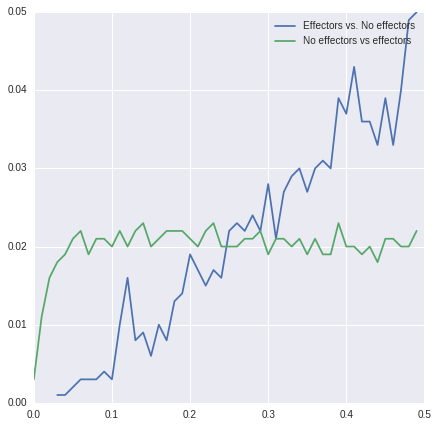

In [56]:
print('Relative distance of between non-effectors and effectors')
fig, ax = plt.subplots(figsize=(7,7))
plt.plot(p_busco_bed.reldist(p_non_busco_bed)['reldist'], p_busco_bed.reldist(p_non_busco_bed)['fraction'], label ='Effectors vs. No effectors')
plt.plot(p_non_busco_bed.reldist(p_busco_bed)['reldist'], p_non_busco_bed.reldist(p_busco_bed)['fraction'], label= 'No effectors vs effectors')

plt.ylim(0, 0.05)
plt.legend()

[]

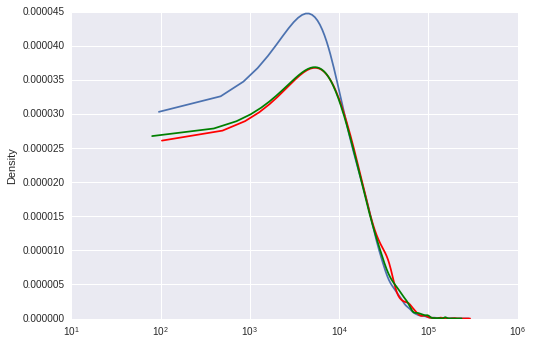

In [57]:
#densities without overlaps between repeats and genes
p_noeffector_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().loc[:,18].plot(kind='density')
p_effector_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().loc[:,18].plot(kind='density', color='r')
p_busco_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().loc[:,18].plot(kind='density', color='g')
plt.semilogx()

[]

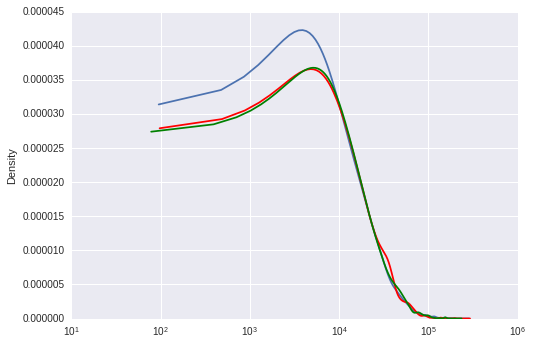

In [58]:
#densities with overlaps between repeats and genes
p_noeffector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().loc[:,18].plot(kind='density')
p_effector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().loc[:,18].plot(kind='density', color='r')
p_busco_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().loc[:,18].plot(kind='density', color='g')
plt.semilogx()

In [59]:
#define repeats
tmp_REPET = pd.read_csv(p_repeat_superfamily_gff_fn, header=None, sep='\t', names=gff_header)
tmp_REPET['distance'] = tmp_REPET.end - tmp_REPET.start
tmp_fn = p_repeat_superfamily_gff_fn.replace('superfamily', 'tmpsuperfamily')
tmp_REPET[tmp_REPET.distance > 400].loc[:,gff_header].to_csv(tmp_fn, header=None, sep='\t', index=None)

p_repeats_bed = BedTool(tmp_fn)

In [60]:
#summary of closest TEs not allowing for overlaps 
#####Needs fixing for genes that don't have a nearest neighbou######
p_br_closest_df = p_busco_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe(names = bed_repeat_closest_header)

p_br_closest_pt = p_br_closest_df.pivot_table(values='distance', index=['attributes_repeat'] ,aggfunc=[ np.count_nonzero, np.mean]).T.unstack().T

p_br_closest_pt['superfamily_%'] = p_br_closest_pt.count_nonzero / p_br_closest_pt.count_nonzero.sum() *100
old_columns =[x for x in p_br_closest_pt.columns] 
new_columns = [x+'_busco' for x in p_br_closest_pt.columns]
p_br_closest_pt.rename(columns=dict(zip(old_columns,new_columns)), inplace = True)

p_er_closest_df = p_effector_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe(names = bed_repeat_closest_header)

p_er_closest_pt = p_er_closest_df.pivot_table(values='distance', index=['attributes_repeat'] ,aggfunc=[ np.count_nonzero, np.mean]).T.unstack().T

p_er_closest_pt['superfamily_%'] = p_er_closest_pt.count_nonzero / p_er_closest_pt.count_nonzero.sum() *100
old_columns =[x for x in p_er_closest_pt.columns] 
new_columns = [x+'_effector' for x in p_er_closest_pt.columns]
p_er_closest_pt.rename(columns=dict(zip(old_columns,new_columns)), inplace = True)

p_ner_closest_df = p_noeffector_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe(names = bed_repeat_closest_header)

p_ner_closest_pt = p_ner_closest_df.pivot_table(values='distance', index=['attributes_repeat'] ,aggfunc=[ np.count_nonzero, np.mean]).T.unstack().T

p_ner_closest_pt['superfamily_%'] = p_ner_closest_pt['count_nonzero'] / p_ner_closest_pt['count_nonzero'].sum() *100
old_columns =[x for x in p_ner_closest_pt.columns] 
new_columns = [x+'_noeffector' for x in p_ner_closest_pt.columns]
p_ner_closest_pt.rename(columns=dict(zip(old_columns,new_columns)), inplace = True)

pd.options.display.float_format = '{:.2f}'.format

repeat_distance_df = pd.concat([p_ner_closest_pt.iloc[:,1:], p_br_closest_pt.iloc[:,1:], p_er_closest_pt.iloc[:,1:]], axis=1)

repeat_distance_df[repeat_distance_df['superfamily_%_effector'] >1].sort_values('superfamily_%_effector')

,,mean_noeffector,superfamily_%_noeffector,mean_busco,superfamily_%_busco,mean_effector,superfamily_%_effector
attributes_repeat,,,,,,,
ClassII:Helitron:?,distance,3139.50,0.96,4449.82,0.76,3995.63,1.21
ClassII:TIR:CACTA,distance,3110.65,2.47,6555.92,0.90,6315.53,1.21
ClassI:DIRS:DIRS,distance,1695.24,1.25,2274.42,1.32,2698.60,1.59
ClassII:TIR:MuDR,distance,2911.69,3.19,4569.71,1.94,2969.60,2.73
noCat,distance,2699.79,2.64,2771.70,2.08,3834.91,2.73
ClassII:TIR:PIF-Harbinger,distance,1974.08,4.58,2674.48,4.43,2050.57,3.24
ClassII:TIR:Tc1-Mariner,distance,3067.33,4.82,3836.76,5.40,4464.65,3.62
ClassI:LTR:?,distance,2495.17,3.93,2769.40,4.36,2808.36,4.45
ClassII:MITE:?,distance,3133.07,3.55,2909.45,5.75,3257.52,5.15


In [61]:
#summary of closest TEs allowing for overlaps
p_br_closest_df = p_busco_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe(names = bed_repeat_closest_header)

p_br_closest_pt = p_br_closest_df.pivot_table(values='distance', index=['attributes_repeat'] ,aggfunc=[ np.count_nonzero, np.mean]).T.unstack().T

p_br_closest_pt['superfamily_%'] = p_br_closest_pt.count_nonzero / p_br_closest_pt.count_nonzero.sum() *100
old_columns =[x for x in p_br_closest_pt.columns] 
new_columns = [x+'_busco' for x in p_br_closest_pt.columns]
p_br_closest_pt.rename(columns=dict(zip(old_columns,new_columns)), inplace = True)

p_er_closest_df = p_effector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe(names = bed_repeat_closest_header)

p_er_closest_pt = p_er_closest_df.pivot_table(values='distance', index=['attributes_repeat'] ,aggfunc=[ np.count_nonzero, np.mean]).T.unstack().T

p_er_closest_pt['superfamily_%'] = p_er_closest_pt.count_nonzero / p_er_closest_pt.count_nonzero.sum() *100
old_columns =[x for x in p_er_closest_pt.columns] 
new_columns = [x+'_effector' for x in p_er_closest_pt.columns]
p_er_closest_pt.rename(columns=dict(zip(old_columns,new_columns)), inplace = True)

p_ner_closest_df = p_noeffector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe(names = bed_repeat_closest_header)

p_ner_closest_pt = p_ner_closest_df.pivot_table(values='distance', index=['attributes_repeat'] ,aggfunc=[ np.count_nonzero, np.mean]).T.unstack().T

p_ner_closest_pt['superfamily_%'] = p_ner_closest_pt['count_nonzero'] / p_ner_closest_pt['count_nonzero'].sum() *100
old_columns =[x for x in p_ner_closest_pt.columns] 
new_columns = [x+'_noeffector' for x in p_ner_closest_pt.columns]
p_ner_closest_pt.rename(columns=dict(zip(old_columns,new_columns)), inplace = True)

pd.options.display.float_format = '{:.2f}'.format

repeat_distance_df = pd.concat([p_ner_closest_pt.iloc[:,1:], p_br_closest_pt.iloc[:,1:], p_er_closest_pt.iloc[:,1:]], axis=1)

repeat_distance_df[repeat_distance_df['superfamily_%_effector'] >1].sort_values('superfamily_%_effector')

,,mean_noeffector,superfamily_%_noeffector,mean_busco,superfamily_%_busco,mean_effector,superfamily_%_effector
attributes_repeat,,,,,,,
ClassII:TIR:CACTA,distance,2307.51,1.88,2993.24,0.77,6750.20,1.19
ClassI:DIRS:DIRS,distance,1399.24,1.02,2160.70,1.47,2282.96,1.51
ClassII:Helitron:?,distance,2827.69,1.17,3765.23,0.85,3995.63,1.51
ClassII:TIR:MuDR,distance,2596.12,3.16,3947.16,2.09,3129.58,2.86
noCat,distance,2523.40,2.79,2868.71,2.17,3752.58,3.17
ClassII:TIR:PIF-Harbinger,distance,1467.07,4.27,2284.90,4.26,1511.71,3.25
ClassI:LTR:?,distance,2214.76,3.97,2485.55,4.57,1964.95,3.49
ClassII:TIR:Tc1-Mariner,distance,2775.31,5.01,3675.42,5.42,3908.29,3.81
ClassII:MITE:?,distance,3250.65,4.47,2998.27,5.96,3260.38,5.71


Add some sub_sets for randommization to get equal sized groups

In [62]:
#set the size of the subset here
sub_set = len(p_busco_bed)

In [63]:
p_effector_bed = BedTool(p_effector_bed_fn)
p_allgene_bed = BedTool(p_gene_bed_fn)
p_busco_bed = BedTool(p_busco_bed_fn)
p_allall_rand_sub = p_allgene_bed.random_subset(sub_set)
p_effector_bed_rand_sub = p_effector_bed.random_subset(sub_set)
p_busco_bed_rand_sub = p_busco_bed.random_subset(sub_set)

In [64]:
p_non_busco_non_effector_bed_fn

'/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/enrichment_analysis/lists/Pst_104E_v12_p_non_busco_non_effector.gene.bed'

In [65]:
#get some randomly subsampled beds of non_busco_non_effectors
p_non_busco_non_effector_bed = BedTool(p_non_busco_non_effector_bed_fn)
p_no_b_no_e_rand_sub = p_non_busco_non_effector_bed.random_subset(sub_set)
for n in range(0,10):
    fn_n = p_non_busco_non_effector_bed_fn.replace('.gene.bed', '.randsub_%s.gene.bed'%n)
    p_no_b_no_e_rand_sub = p_non_busco_non_effector_bed.random_subset(sub_set)
    p_no_b_no_e_rand_sub.to_dataframe().to_csv(fn_n, sep='\t', header=None, index=None)


count     1421.00
mean     22078.92
std      33321.13
min        133.00
25%       3315.00
50%       9822.00
75%      26264.00
max     357617.00
Name: Effectors, dtype: float64


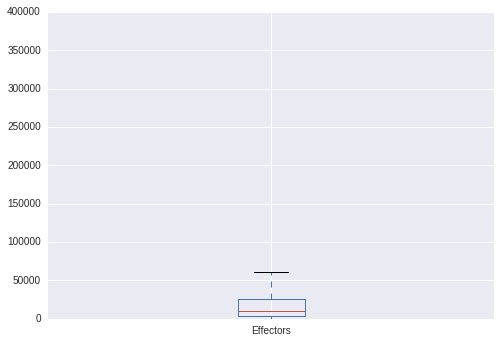

In [66]:
#get the distances with nearest gene effectors vs effectors
p_eself = p_effector_bed_rand_sub.closest(p_effector_bed_rand_sub, d=True,  N=True).to_dataframe().iloc[:,12]
p_eself = p_eself[p_eself > -1]
p_eself.name = 'Effectors'
p_eall = p_effector_bed_rand_sub.closest(p_allall_rand_sub, d=True,  N=True).to_dataframe().iloc[:,12]
p_eall= p_eall[p_eall > -1]
print(p_eself.describe())
p_eself.plot(kind='box')

count     1427.00
mean     27843.56
std      34034.33
min         20.00
25%       6368.00
50%      17334.00
75%      38318.00
max     373679.00
Name: All_genes, dtype: float64


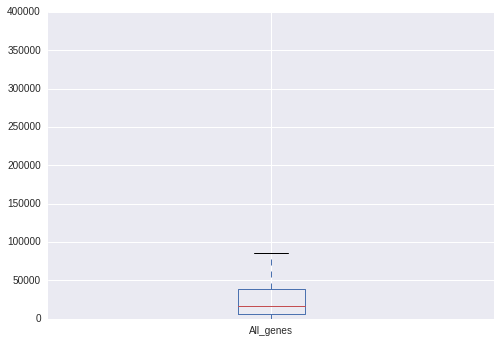

In [67]:
#get the distances with nearest gene all vs all subsampled
p_allall = p_allall_rand_sub.closest(p_allall_rand_sub, d=True, N=True).to_dataframe().iloc[:,12]
p_allall = p_allall[p_allall > -1]
p_allall.name = 'All_genes'
print(p_allall.describe())
p_allall.plot(kind='box')

count     1431.00
mean     24105.67
std      32325.42
min         44.00
25%       4692.00
50%      13565.00
75%      29552.00
max     318595.00
Name: BUSCO, dtype: float64


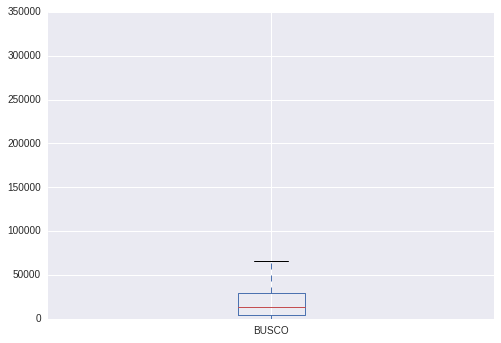

In [68]:
#now with buscos
p_bself = p_busco_bed_rand_sub.closest(p_busco_bed_rand_sub, d=True,  N=True).to_dataframe().iloc[:,12]
p_bself = p_bself[p_bself > -1]
p_bself.name = 'BUSCO'
print(p_bself.describe())
p_bself.plot(kind='box')

count     1424.00
mean     28355.10
std      33495.59
min         55.00
25%       6788.50
50%      18087.00
75%      36561.00
max     352684.00
Name: No_effectors, dtype: float64


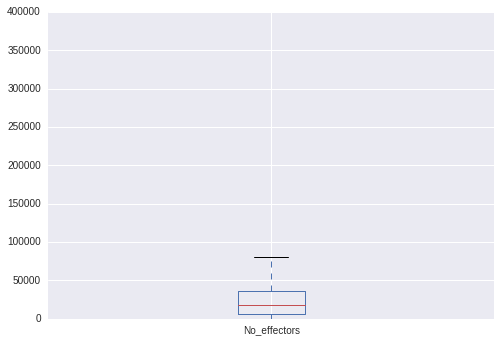

In [69]:
#non_effectors
p_noeffector_bed= BedTool(p_noeffector_bed_fn)
p_noeffector_rand_sub = p_noeffector_bed.random_subset(sub_set)
p_neself = p_noeffector_rand_sub.closest(p_noeffector_rand_sub, d=True,  N=True).to_dataframe().iloc[:,12]
p_neself = p_neself[p_neself > -1]
p_neself.name = 'No_effectors'
print(p_neself.describe())
p_neself.plot(kind='box')

Look if effectors and BUSCOs are actually linked
The question is if effectors are close to buscos than other genes. So do busco and effectors link together.

-> are busco more likely closest genes to effectors and vice versa
-> are the distance between busco and random genes larger than busco and effectors

effectors distance to closest Busco


count     1432.00
mean     24805.33
std      33257.69
min        281.00
25%       4370.00
50%      13894.00
75%      33392.25
max     339166.00
Name: Closest Busco to effector, dtype: float64

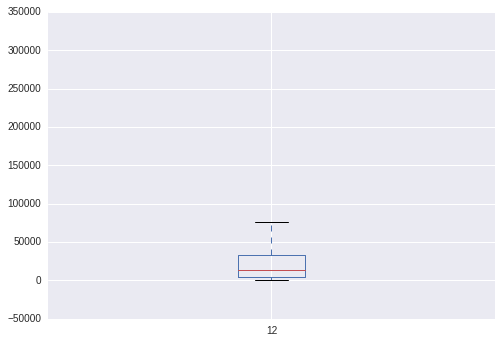

In [70]:
print('effectors distance to closest Busco')
p_effector_bed_rand_sub.closest(p_busco_bed_rand_sub, d=True,t='last', io=True).to_dataframe().boxplot(column=12)
effector_busco_c_df = p_effector_bed_rand_sub.closest(p_busco_bed_rand_sub, d=True,t='last', io=True).to_dataframe().iloc[:,12]
effector_busco_c_df = effector_busco_c_df[effector_busco_c_df>-1]
effector_busco_c_df.name = "Closest Busco to effector"
effector_busco_c_df.describe()

Closest effector to busco


count     1432.00
mean     30123.43
std      38051.02
min        281.00
25%       4978.00
50%      15958.00
75%      40689.00
max     287609.00
Name: Closest effector to busco, dtype: float64

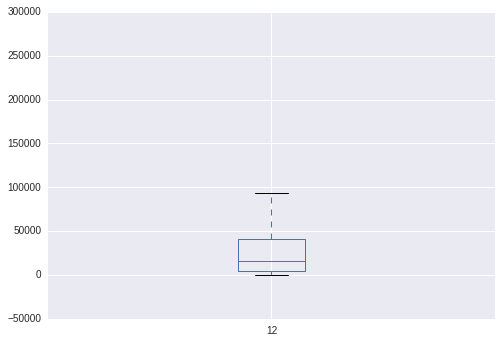

In [71]:
print('Closest effector to busco')
p_busco_bed_rand_sub.closest(p_effector_bed_rand_sub, d=True,t='last', io=True).to_dataframe().boxplot(column=12)
busco_effector_c_df = p_busco_bed_rand_sub.closest(p_effector_bed_rand_sub, d=True,t='last', io=True).to_dataframe().iloc[:,12]
busco_effector_c_df = busco_effector_c_df[busco_effector_c_df>-1]
busco_effector_c_df.name = 'Closest effector to busco'
busco_effector_c_df.describe()

effectors distance to closest rand


count     1435.00
mean     26452.93
std      31143.73
min         14.00
25%       5851.50
50%      16648.00
75%      35135.50
max     315421.00
Name: Closest randsubset to effector, dtype: float64

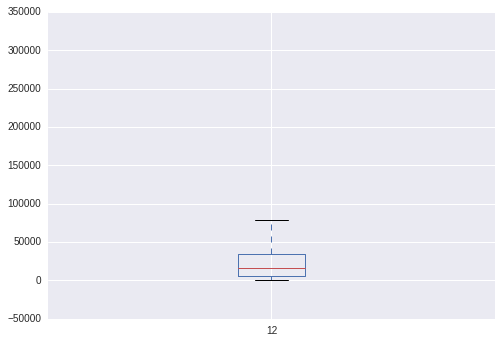

In [72]:
print('effectors distance to closest rand')
p_effector_bed_rand_sub.closest(p_allall_rand_sub, d=True,t='last', io=True).to_dataframe().boxplot(column=12)
effector_randsubset_c_df = p_effector_bed_rand_sub.closest(p_allall_rand_sub, d=True,t='last', io=True).to_dataframe().iloc[:,12]
effector_randsubset_c_df = effector_randsubset_c_df[effector_randsubset_c_df>-1]
effector_randsubset_c_df.name =  "Closest randsubset to effector"
effector_randsubset_c_df.describe()

busco distance to closest rand


count     1428.00
mean     29369.31
std      42732.32
min         16.00
25%       6486.00
50%      16975.50
75%      36265.00
max     431344.00
Name: Closest rand sub to BUSCO, dtype: float64

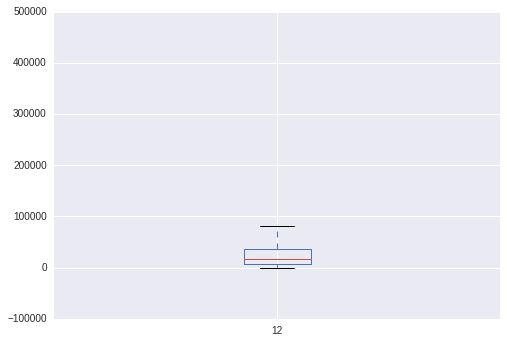

In [73]:
print('busco distance to closest rand')
p_busco_bed_rand_sub.closest(p_allall_rand_sub, d=True,t='last', io=True).to_dataframe().boxplot(column=12)
busco_rand_sub_c_df = p_busco_bed_rand_sub.closest(p_allall_rand_sub, d=True,t='last', io=True).to_dataframe().iloc[:,12]
busco_rand_sub_c_df = busco_rand_sub_c_df[busco_rand_sub_c_df>-1]
busco_rand_sub_c_df.name = "Closest rand sub to BUSCO"
busco_rand_sub_c_df.describe()

rand to closest busco


count     1414.00
mean     33951.45
std      46578.25
min         16.00
25%       6578.00
50%      18387.00
75%      41256.25
max     396935.00
Name: Closest BUSCO to rand subset, dtype: float64

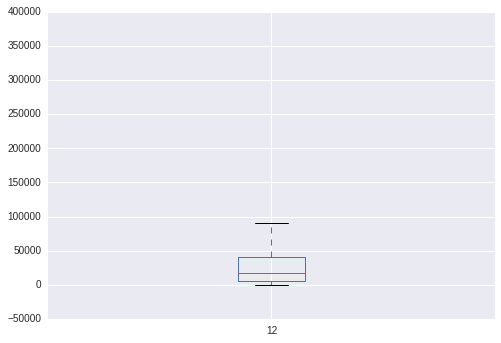

In [74]:
print('rand to closest busco')
p_allall_rand_sub.closest(p_busco_bed_rand_sub, d=True,t='last', io=True).to_dataframe().boxplot(column=12)
rand_sub_busco_c_df = p_allall_rand_sub.closest(p_busco_bed_rand_sub, d=True,t='last', io=True).to_dataframe().iloc[:,12]
rand_sub_busco_c_df = rand_sub_busco_c_df[rand_sub_busco_c_df>-1]
rand_sub_busco_c_df.name = 'Closest BUSCO to rand subset'
rand_sub_busco_c_df.describe()

Rand to closest effector


count     1407.00
mean     38760.04
std      47141.56
min         14.00
25%       6538.50
50%      21951.00
75%      54925.00
max     366580.00
Name: Closest effector to rand subset, dtype: float64

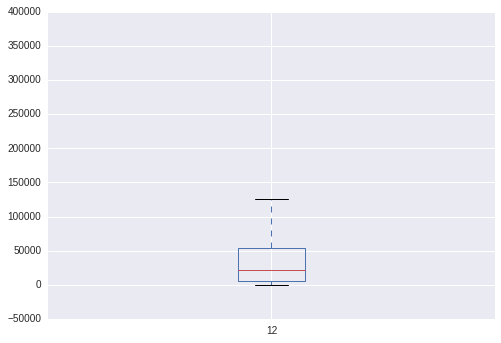

In [75]:
print('Rand to closest effector')
p_allall_rand_sub.closest(p_effector_bed_rand_sub, d=True,t='last', io=True).to_dataframe().boxplot(column=12)
rand_subset_effector_c_df = p_allall_rand_sub.closest(p_effector_bed_rand_sub, d=True,t='last', io=True).to_dataframe().iloc[:,12]
rand_subset_effector_c_df = rand_subset_effector_c_df[rand_subset_effector_c_df>-1]
rand_subset_effector_c_df.name ='Closest effector to rand subset'
rand_subset_effector_c_df.describe()

In [76]:
#all against others both ways to see if effectors are closer to buscos compared to random subset
all_vs_others_c_df = \
 pd.concat([busco_effector_c_df,rand_subset_effector_c_df,effector_busco_c_df,rand_sub_busco_c_df,  \
             effector_randsubset_c_df, busco_rand_sub_c_df ], axis=1)

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

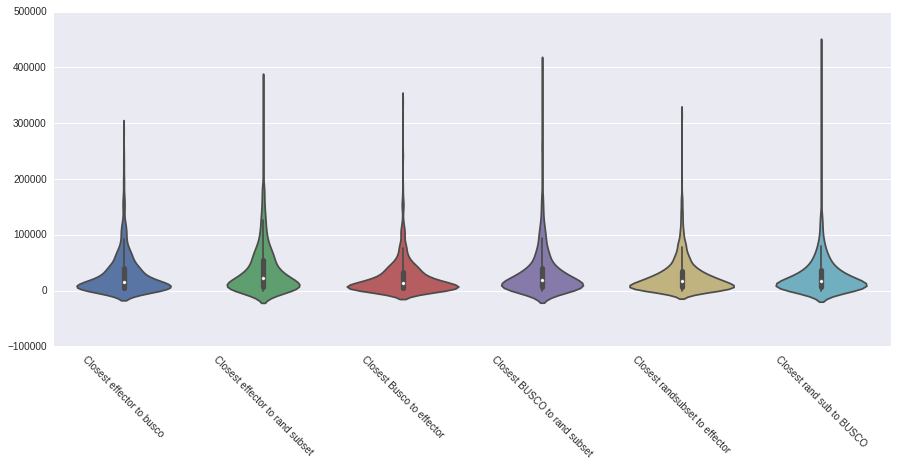

In [77]:
fig, ax = plt.subplots(figsize=(15,6))
sns.violinplot(data=all_vs_others_c_df)
plt.xticks(rotation=-45)

In [78]:
#define a function that subsets a dataframe to the inner quantil residual columnwise
def quant_cut_df(dataframe):
    nn_df = dataframe.copy()
    iqr_df_low = nn_df.apply(lambda x: x.quantile(0.25) - 1.5*(x.quantile(0.75) - x.quantile(0.25)) )
    iqr_df_low.name ='low'
    iqr_df_high = nn_df.apply(lambda x: x.quantile(0.75) + 1.5*(x.quantile(0.75) - x.quantile(0.25)) )
    iqr_df_high.name = 'high'

    iqr_df = pd.concat([iqr_df_low, iqr_df_high], axis=1).T

    iqr_nn_df = nn_df.apply(lambda x: x[(x > iqr_df.loc['low', x.name]) & (x  < iqr_df.loc['high', x.name])], axis=0)
    return iqr_nn_df 



(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

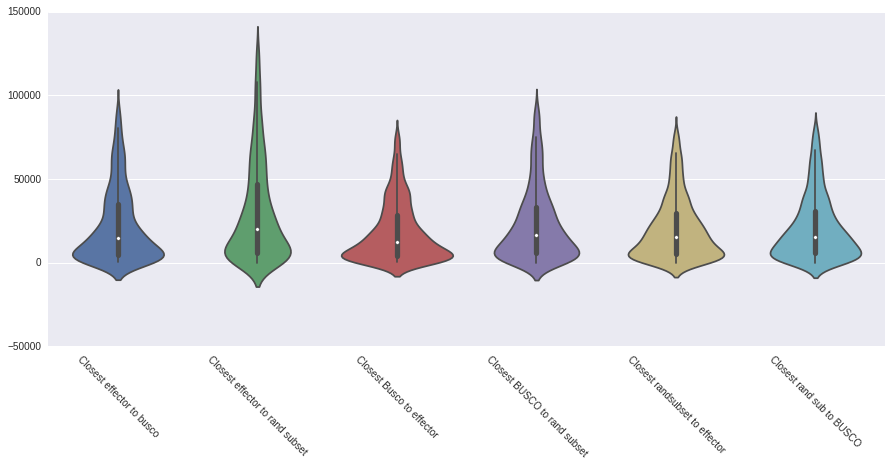

In [79]:
#plot the violine plots for distances once teh iqr is present only
all_vs_others_iqr_df = quant_cut_df(all_vs_others_c_df)
fig, ax = plt.subplots(figsize=(15,6))
sns.violinplot(data=all_vs_others_iqr_df)
plt.xticks(rotation=-45)

In [80]:
all_vs_others_iqr_df.columns

Index(['Closest effector to busco', 'Closest effector to rand subset',
       'Closest Busco to effector', 'Closest BUSCO to rand subset',
       'Closest randsubset to effector', 'Closest rand sub to BUSCO'],
      dtype='object')

In [81]:
#do some stats on it look first into ranksum test
scipy.stats.ranksums(all_vs_others_c_df['Closest effector to busco'], all_vs_others_c_df['Closest effector to rand subset'])

RanksumsResult(statistic=-5.708387048751721, pvalue=1.1405182654286582e-08)

In [82]:
scipy.stats.ranksums(all_vs_others_c_df['Closest Busco to effector'], all_vs_others_c_df['Closest BUSCO to rand subset'])

RanksumsResult(statistic=-5.9629252849949079, pvalue=2.4776173017388841e-09)

In [83]:
scipy.stats.mannwhitneyu(all_vs_others_c_df['Closest Busco to effector'], all_vs_others_c_df['Closest BUSCO to rand subset'],use_continuity=True, alternative='two-sided')

MannwhitneyuResult(statistic=908967.0, pvalue=2.4779526661073755e-09)

In [84]:
scipy.stats.mannwhitneyu(all_vs_others_c_df['Closest effector to busco'], all_vs_others_c_df['Closest effector to rand subset'],use_continuity=True, alternative='two-sided')

MannwhitneyuResult(statistic=914670.0, pvalue=1.1406665220142075e-08)

In [85]:
all_vs_others_iqr_melt = all_vs_others_iqr_df.melt()

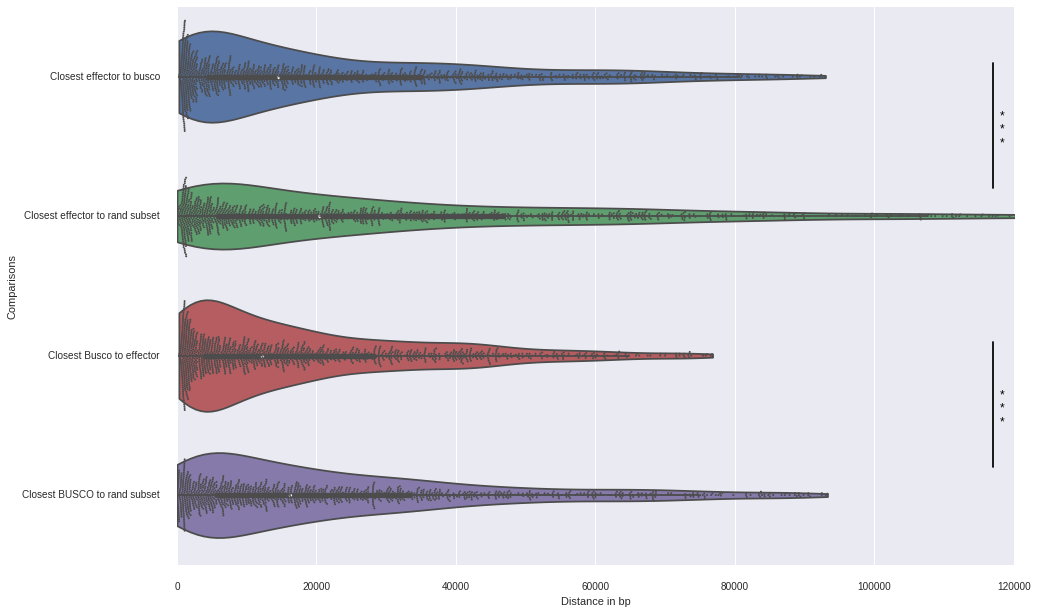

In [86]:
df = all_vs_others_iqr_melt\
    [all_vs_others_iqr_melt.variable.isin(all_vs_others_iqr_df.iloc[:,[0,1,2,3]].columns)].copy()
#do a boxplot and swarmplot on the same data
f, ax = plt.subplots(figsize=(15, 10))
#ax.set_xscale("log")
sns.violinplot(x="value", y="variable", data=df, cut=0,
          whis=np.inf)
plt.setp(ax.artists, alpha=.01)
sns.swarmplot(x="value", y="variable", data=df,
              size=2, color=".3", linewidth=0)
plt.xlim(0, 120000)
plt.ylabel("Comparisons")
plt.xlabel('Distance in bp')
ax.text(118000, 0.5, '*\n*\n*', color='k')
ax.plot([117000, 117000],[-0.1, 0.8], color ='k' )
ax.text(118000, 2.5, '*\n*\n*', color='k')
ax.plot([117000, 117000],[1.9, 2.8], color ='k' )
sns.despine(offset=10, trim=True)

In [87]:
#do a boxplot on the same data using own bining
bins = [x for x in range(0, int(all_vs_others_iqr_df.max().max())+10000,2000 )]
all_vs_others_iqr_melt['bins'] = pd.cut(all_vs_others_iqr_melt.value, bins)
all_vs_others_iqr_hist = all_vs_others_iqr_melt.groupby(by=['variable', 'bins']).count().unstack().T

In [88]:
all_vs_others_iqr_hist['bins'] = all_vs_others_iqr_hist.index.get_level_values(1)

all_vs_others_iqr_hist['bins_left'] = all_vs_others_iqr_hist['bins'].apply(lambda x: x.left)

(-500, 126844.0)

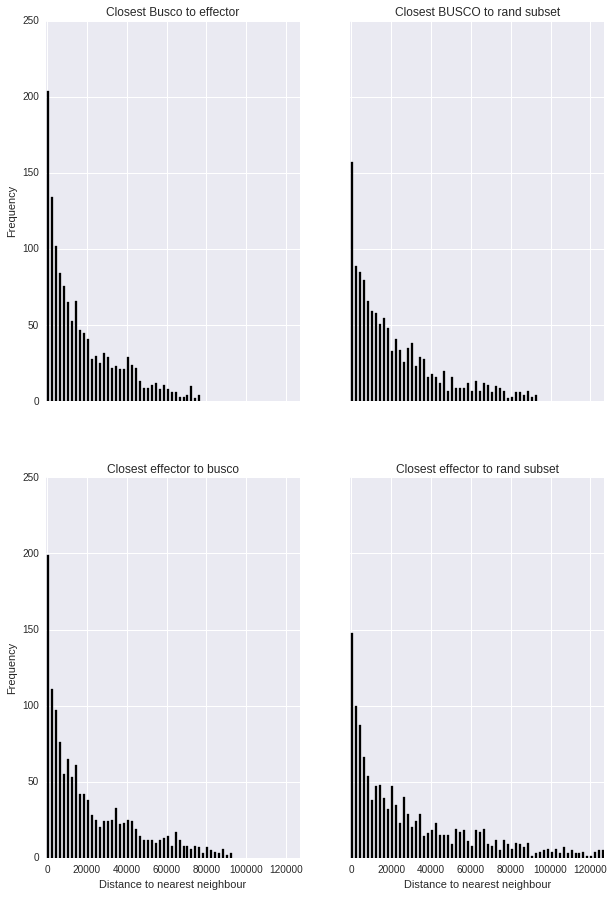

In [89]:
df = all_vs_others_iqr_hist.copy()
_max = all_vs_others_iqr_df.max().max()
fig, ax = plt.subplots(2,2, figsize=(10,15), sharex='all', sharey='all')
for axes, data in zip(ax.flat,  df.iloc[:,[1,0,2,3]].columns ):
    axes.bar(left=  df['bins_left'],height=df.loc[:,data],\
            color='k',width=1000)
    axes.set_title(data)
    
ax[1,0].set_xlabel('Distance to nearest neighbour')
ax[1,1].set_xlabel('Distance to nearest neighbour')
ax[0,0].set_ylabel('Frequency')
ax[1,0].set_ylabel('Frequency')
plt.xlim(-500, _max)

In [90]:
#all_vs_others_iqr_hist.cumsum(axis=0)['Closest Busco to effector'] - all_vs_others_iqr_hist.cumsum(axis=0)['Closest BUSCO to rand subset']

In [91]:
#all_vs_others_iqr_hist.cumsum(axis=0)['Closest effector to busco'] - all_vs_others_iqr_hist.cumsum(axis=0)['Closest effector to rand subset']

In [93]:
#do a boxplot bin the data into same intervals for all and make new data frame out of it
all_vs_others_c_df_melt = all_vs_others_c_df.melt()
bins = [x for x in range(0, int(all_vs_others_c_df_melt.value.max())+10000,2000 )]
all_vs_others_c_df_melt['bins'] = pd.cut(all_vs_others_c_df_melt.value, bins)
all_vs_others_c_df_hist = all_vs_others_c_df_melt.groupby(by=['variable', 'bins']).count().unstack().T
all_vs_others_c_df_hist['bins'] = all_vs_others_c_df_hist.index.get_level_values(1)
all_vs_others_c_df_hist['bins_left'] = all_vs_others_c_df_hist['bins'].apply(lambda x: x.left)


(-500, 431344.0)

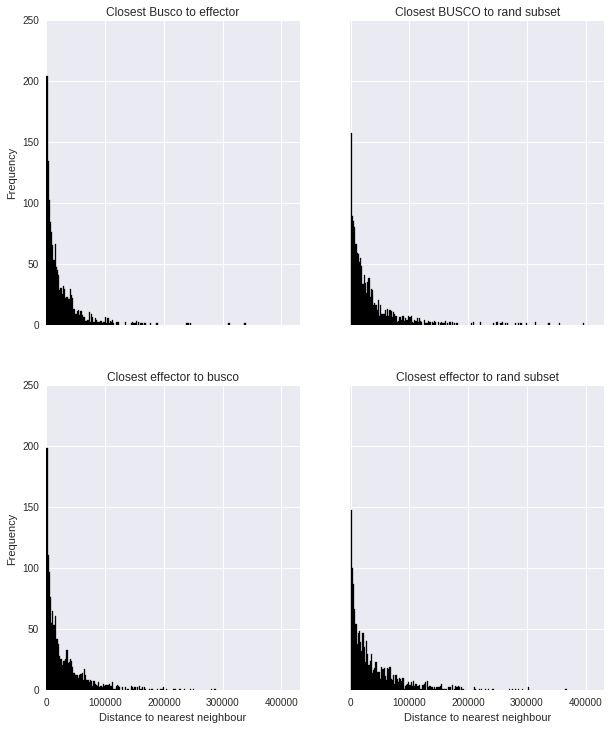

In [94]:
df = all_vs_others_c_df_hist.copy()
_max = all_vs_others_c_df_melt.value.max()
fig, ax = plt.subplots(2,2, figsize=(10,12), sharex='all', sharey='all')
for axes, data in zip(ax.flat,  df.iloc[:,[1,0,2,3]].columns ):
    axes.bar(left=  df['bins_left'],height=df.loc[:,data],\
            color='k',width=2000)
    axes.set_title(data)
    
ax[1,0].set_xlabel('Distance to nearest neighbour')
ax[1,1].set_xlabel('Distance to nearest neighbour')
ax[0,0].set_ylabel('Frequency')
ax[1,0].set_ylabel('Frequency')
plt.xlim(-500, _max)
#all_vs_others_iqr_df.hist(bins=30, figsize=(15,10), sharey='All', sharex="All")

cat Pst_104E_v12_ph_ctg.no_alleles_postQC.txt | xargs -I {} grep "{}" ../../enrichment_analysis/lists/Pst_104E_v12_p_effector.list > ../../enrichment_analysis/lists/Pst_104E_v12_p_effector.noalleles.list

In [100]:
!ls {OUT_FOLDER}

Pst_104E_v12_cluster_8.gene.bed
Pst_104E_v12_cluster_8.gene.gff3
Pst_104E_v12_cluster_8.list
Pst_104E_v12_h_all.gene.gff3
Pst_104E_v12_h_busco.gene.gff3
Pst_104E_v12_h_busco.list
Pst_104E_v12_h_ctg.REPET.gff
Pst_104E_v12_h_ctg.REPET.sorted.superfamily.gff
Pst_104E_v12_h_effector.gene.gff3
Pst_104E_v12_h_effector.list
Pst_104E_v12_h_effector.protein.fasta
Pst_104E_v12_h_noeffector.gene.gff3
Pst_104E_v12_h_noeffector.list
Pst_104E_v12_p_all.gene.bed
Pst_104E_v12_p_all.gene.gff3
Pst_104E_v12_p_busco.gene.bed
Pst_104E_v12_p_busco.gene.gff3
Pst_104E_v12_p_busco.list
Pst_104E_v12_p_ctg.REPET.gff
Pst_104E_v12_p_ctg.REPET.sorted.greater400.superfamily.gff
Pst_104E_v12_p_ctg.REPET.sorted.superfamily.gff
Pst_104E_v12_p_ctg.REPET.sorted.tmpsuperfamily.bed
Pst_104E_v12_p_ctg.REPET.sorted.tmpsuperfamily.gff
Pst_104E_v12_p_effector.gene.bed
Pst_104E_v12_p_effector.gene.gff3
Pst_104E_v12_p_effector.list
Pst_104E_v12_p_effector.noalleles.list
Pst_104E_v12_p_effectorp_noeffector.gene.bed
Pst_104E_v12_p

In [130]:
#check if effectors without alleles look any different.
orphan_effectors_list = pd.read_csv(os.path.join(OUT_FOLDER,'Pst_104E_v12_p_Cluster8_UnderDiversifyingSelection.list')\
                                   , sep='\t', header=None)[0].tolist()

In [137]:
effector_list = pd.read_csv(os.path.join(OUT_FOLDER,'Pst_104E_v12_p_effector.list')\
                                   , sep='\t', header=None)[0].tolist()
busco_list = pd.read_csv(os.path.join(OUT_FOLDER,'Pst_104E_v12_p_busco.list')\
                                   , sep='\t', header=None)[0].tolist()

In [142]:
count = 0
for x in effector_list:
    if x in busco_list:
        count = count +1
print(count)

2


In [139]:
len(set(effector_list) -set(busco_list))

1572

In [131]:
test_df  = p_effector_bed_rand_sub.closest(p_busco_bed_rand_sub, d=True,t='last', io=True).to_dataframe()

In [135]:
test_df[test_df[3].str.replace('TU', 'model').isin(orphan_effectors_list)].loc[:,12].describe()

count      58.00
mean    14566.17
std     17224.73
min        -1.00
25%      4145.50
50%      9051.50
75%     16853.75
max     87415.00
Name: 12, dtype: float64

In [134]:
test_df.loc[:,12].describe()

count     1444.00
mean     24599.18
std      33195.64
min         -1.00
25%       4245.50
50%      13465.00
75%      33101.00
max     339166.00
Name: 12, dtype: float64

No look a bit more into the distribution of the nearest neighbour distance

In [ ]:
import seaborn as sns

In [ ]:
sns.distplot(p_bself[p_bself < 10000], bins=20, rug = True, color='g',label='BUSCO')
sns.distplot(p_eself[p_eself < 10000], bins=20, rug = True, color='red',label = 'effector')
sns.distplot(p_neself[p_neself <10000], bins=20, rug=True, color='yellow', label ='not_effectors')
plt.legend()

In [ ]:
sns.distplot(p_bself[p_bself < 200000], bins=20, color='g' ,label='BUSCO')
sns.distplot(p_eself[p_eself < 200000], bins=20,  color='red',label = 'effector')
sns.distplot(p_neself[p_neself <200000], bins=20,  color='yellow', label ='not_effectors', axlabel='Distance to closest neighbour [bp]')
plt.legend()

In [ ]:
sns.distplot(p_bself, bins=20,color='g',  label='BUSCO')
sns.distplot(p_eself, bins=20,  color='red',label = 'effector')
sns.distplot(p_allall, bins=20,  color='b',label = 'all')
sns.distplot(p_neself, bins=20,  color='yellow', label ='not_effectors', axlabel='Distance to closest neighbour [bp]')
plt.legend()

In [ ]:
#now make a nearest neightbour dataframe
nn_df = pd.concat([p_allall, p_bself, p_eself], names=['All_genes', 'BUSCO', 'effectors'], axis=1)

In [ ]:
sns.violinplot(data=nn_df, palette="Set3")

In [ ]:
#NOW FILTER BY QUANTIELS

In [ ]:
low = 0
high = 0.8
quant_df = nn_df.quantile([low,high])

qfilt_nn_df = nn_df.apply(lambda x: x[(x > quant_df.loc[low, x.name]) & (x  < quant_df.loc[high, x.name])], axis=0)

sns.violinplot(data=qfilt_nn_df , palette="Set3")

In [ ]:
#now filter on IQR

In [ ]:
iqr_df_low = nn_df.apply(lambda x: x.quantile(0.25) - 1.5*(x.quantile(0.75) - x.quantile(0.25)) )
iqr_df_low.name ='low'
iqr_df_high = nn_df.apply(lambda x: x.quantile(0.75) + 1.5*(x.quantile(0.75) - x.quantile(0.25)) )
iqr_df_high.name = 'high'

iqr_df = pd.concat([iqr_df_low, iqr_df_high], axis=1).T

iqr_nn_df = nn_df.apply(lambda x: x[(x > iqr_df.loc['low', x.name]) & (x  < iqr_df.loc['high', x.name])], axis=0)
plt.title('Violine plot of nearest neighbour in the same category')
sns.violinplot(data=iqr_nn_df  , palette="Set3")

In [ ]:
p_bself[p_bself < 20000].plot(kind='density')
p_eself[p_eself < 20000].plot(kind='density', color='g')
p_neself[p_neself < 20000].plot(kind='density', color='r')
p_eall[p_eall < 20000].plot(kind='density', color='y')
#plt.semilogx()
print(len(p_bself[p_bself < 20000]), len(p_eself[p_eself < 20000]), len(p_neself[p_neself < 20000]), len(p_eall[p_eall < 20000]))
plt.xlim(0, 20000)

In [ ]:
p_eall[p_eall].plot(kind='hist', bins=20, normed=True)
plt.ylim(0, 0.00020)

In [ ]:
p_eself[p_eself].plot(kind='hist', bins=20, normed=True)
plt.ylim(0, 0.00020)

In [ ]:
p_bself[p_bself ].plot(kind='hist', bins=20,normed=True)
plt.ylim(0, 0.00020)

In [ ]:
p_neself[p_neself ].plot(kind='hist',bins=20,normed=True)
plt.ylim(0, 0.00020)

It seems like there seems to be no clear link between effector candidates and closest neighbour in terms of TEs in general. They all have the same distance in general.
Maybe Gypsy and ClassII:?:? should be looked at more carefully. Those are depleted and enriched in busco and effector genes. In general there seems to be a trend towards ClassII elements compared to ClassI in effector candidates.
This changes when for allowing for overlaps.

It seems that effectors are closer together than noneffector genes. Buscos also seem to cluster a bit. Let's see if we can visualize the location of genes on certain contigs vs repeats and such.

In [ ]:
#start with getting effectors per contig divided by length divded by # of overall genes

In [ ]:
#get effectors per contig
effector_bdf = pd.read_csv(p_effector_bed_fn, header=None, sep='\t')

In [ ]:
p_effectors_per_contig  = effector_bdf.groupby(0).count()[1]
p_effectors_per_contig.name = 'effectors'

In [ ]:
#get all others counts per contig
p_all_genes_per_contig = pd.read_csv(p_gene_bed_fn, header=None, sep='\t').groupby(0).count()[1]
p_all_genes_per_contig.name = 'all_genes'
p_noeffectors_per_contig = pd.read_csv(p_noeffector_bed_fn, header=None, sep='\t').groupby(0).count()[1]
p_noeffectors_per_contig.name = 'no_effectors'
p_busco_per_contig = pd.read_csv(p_busco_bed_fn, header=None, sep='\t').groupby(0).count()[1]
p_busco_per_contig.name = 'buscos'

In [ ]:
#read in the genome file that contains the length of each contig in the second column
p_contig_length = pd.read_csv(os.path.join(GFF_FOLDER, 'Pst_104E_v12_p_ctg.genome_file'), header = None,\
                          names=['contig' , 'length'], sep='\t').sort_values('contig')

In [ ]:
p_contig_length.index = p_contig_length.contig

p_contig_length = p_contig_length.loc[:, 'length']

gene_dis_per_contig = pd.concat([p_contig_length,p_all_genes_per_contig,p_noeffectors_per_contig,p_busco_per_contig,  p_effectors_per_contig ], axis = 1)

In [ ]:
from scipy.stats import chisquare

In [ ]:
#fill nan with 0s
gene_dis_per_contig.fillna(value=0, inplace=True)

In [ ]:
gene_dis_per_contig.effectors.sum()

In [ ]:
#chisquare for genes per contig vs bases per contig
chisquare(gene_dis_per_contig.length.values/gene_dis_per_contig.length.sum()\
          , gene_dis_per_contig.all_genes.values/gene_dis_per_contig.all_genes.sum())

In [ ]:
chisquare(gene_dis_per_contig.buscos.values/gene_dis_per_contig.buscos.sum()\
          , gene_dis_per_contig.all_genes.values/gene_dis_per_contig.all_genes.sum())

In [ ]:
#calculate the % of each category that are on a specific contig
gene_dis_per_contig['%busco'] = gene_dis_per_contig.buscos.values/gene_dis_per_contig.buscos.sum() *100
gene_dis_per_contig['%effector'] = gene_dis_per_contig.effectors.values/gene_dis_per_contig.effectors.sum() *100
gene_dis_per_contig['%all_genes'] = gene_dis_per_contig.all_genes.values/gene_dis_per_contig.all_genes.sum() *100
gene_dis_per_contig['%no_effector'] = gene_dis_per_contig.no_effectors.values/gene_dis_per_contig.no_effectors.sum() *100

In [ ]:
#not sure why this isn't working
chisquare(gene_dis_per_contig['%effector'], f_exp = gene_dis_per_contig['%all_genes'])

In [ ]:
#have a look at the different percentages
gene_dis_per_contig.loc[:,['%effector', '%all_genes','%no_effector' ,'%busco']]

In [ ]:
#contigs which % effectors is more than % of all genes or of buscos
gene_dis_per_contig[(gene_dis_per_contig['%effector'] > gene_dis_per_contig['%all_genes']) &\
                    (gene_dis_per_contig['%effector'] > gene_dis_per_contig['%busco'])].loc[:,['effectors', '%effector', '%all_genes']].index

In [ ]:
#contigs which % effectors is more than % of all genes or of buscos
gene_dis_per_contig[(gene_dis_per_contig['%effector'] > gene_dis_per_contig['%all_genes']) &\
                    (gene_dis_per_contig['%effector'] > gene_dis_per_contig['%busco'])].loc[:,['effectors', '%effector', '%all_genes', '%busco']]

In [ ]:
%%R
setwd("/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/enrichment_analysis/lists")
getwd()
busco_bed <- import("Pst_104E_v12_p_busco.gene.bed", format ='bed')
effector_bed <- import("Pst_104E_v12_p_effector.gene.bed", format='bed')
no_effector_bed <- import("Pst_104E_v12_p_effectorp_noeffector.gene.bed", format='bed')
#Pst_104E_seqinfo <- import("../../../032017_assembly/Pst_104E_v12_p_ctg.genome_file", as = "Rle")
#Pst_104E_seqinfo
#effector_bed
pn.area <- 100
pn.dist <- 100
pn.jacc <- 100
effector_to_busco_bed <- GenometriCorr:::GenometriCorrelation(effector_bed, busco_bed,  chromosomes.to.proceed = c("pcontig_001"), ecdf.area.permut.number = pn.area,mean.distance.permut.number = pn.dist,jaccard.measure.permut.number = pn.jacc,keep.distributions = TRUE, showProgressBar = FALSE)
print(effector_to_busco_bed)

In [ ]:
%%R
GenometriCorr:::graphical.report(effector_to_busco_bed, pdffile = "../figures/Pst_104E_p_effector_to_busco_bed_pcontig_001.pdf",  show.all = TRUE)

In [ ]:
#this moves the file to a folder were jupyter can access it for displaying.
copyanything(OUT_FOLDER_FIG, TMP_FIG_PATH)

In [ ]:
PDF('Pst_104E_p_effector_to_no_effector.pdf')

In [ ]:
PDF('Pst_104E_p_effector_to_busco.pdf')

In [ ]:
PDF('Pst_104E_p_effector_to_busco_vis.pdf')

In [ ]:
PDF('Pst_104E_p_effector_to_no_effector_vis.pdf')

In [ ]:
#effectors per contig > than expected 1.5 increase?
gene_dis_per_contig[(gene_dis_per_contig['%effector'] / gene_dis_per_contig['%all_genes']) > 1.5].loc[:,['effectors', '%effector', 'all_genes','%all_genes']].index

In [ ]:
#sum off all effectors on enriched? contigs
gene_dis_per_contig[(gene_dis_per_contig['%effector'] > gene_dis_per_contig['%all_genes']) &\
                    (gene_dis_per_contig['%effector'] > gene_dis_per_contig['%busco'])].sum()

In [ ]:
#sum off all effectors on enriched? contigs
gene_dis_per_contig[(gene_dis_per_contig['%effector'] > gene_dis_per_contig['%all_genes']) &\
                    (gene_dis_per_contig['%all_genes'] > gene_dis_per_contig['%busco'])].sum()

In [ ]:
#sum off all effectors on enriched? contigs
gene_dis_per_contig[(gene_dis_per_contig['%effector'] > gene_dis_per_contig['%all_genes']) ].sum()

In [ ]:
#sum off all effectors on enriched? contigs
gene_dis_per_contig[(gene_dis_per_contig['%busco'] > gene_dis_per_contig['%all_genes'])].sum()

In [ ]:
#sum off all effectors on enriched? contigs
gene_dis_per_contig[(gene_dis_per_contig['%effector'] > gene_dis_per_contig['%all_genes']) ].sum()

In [ ]:
gene_dis_per_contig[(gene_dis_per_contig['%busco'] / gene_dis_per_contig['%all_genes'] > 1.2) & (gene_dis_per_contig['%busco'] > 0.5 )\
                    ].loc[:,['buscos', '%busco', '%all_genes']]

In [ ]:
gene_dis_per_contig[(gene_dis_per_contig['%busco'] / gene_dis_per_contig['%all_genes'] > 1.2) \
                    ].sum()

In [ ]:
gene_dis_per_contig[(gene_dis_per_contig['%busco'] / gene_dis_per_contig['%all_genes'] > 1.1) & \
                   (gene_dis_per_contig['%effector'] / gene_dis_per_contig['%all_genes'] < 0.9) ].sum()

In [ ]:
gene_dis_per_contig[(gene_dis_per_contig['%busco'] / gene_dis_per_contig['%all_genes'] > 1.0000001) & \
                   (gene_dis_per_contig['%effector'] / gene_dis_per_contig['%all_genes'] < 0.9999) ].sum()

In [ ]:
#enriched for effectors relative to busco and all genes. Seems to be the case that their might be contigs
#with less BUSCOs and more effectors
gene_dis_per_contig[(gene_dis_per_contig['%busco'] / gene_dis_per_contig['%effector'] < 1) & \
                    (gene_dis_per_contig['%all_genes'] / gene_dis_per_contig['%effector'] < 1) ].sum()

Get closest features genes vs. TEs

In [ ]:
tmp_REPET = pd.read_csv(p_repeat_superfamily_gff_fn, header=None, sep='\t', names=gff_header)
tmp_REPET['distance'] = tmp_REPET.end - tmp_REPET.start

tmp_fn = p_repeat_superfamily_gff_fn.replace('superfamily.gff', 'tmpsuperfamily.bed')
tmp_REPET[tmp_REPET.distance > 400].loc[:,['seqid', 'start', 'end', 'attributes', 'score', 'strand']].to_csv(tmp_fn, header=None, sep='\t', index=None)

p_repeats_bed = BedTool(tmp_fn)

In [ ]:
tmp_df = p_effector_bed.closest( [p_repeats_bed.fn,p_allgene_bed.fn] , mdb='all', d=True, N=True).to_dataframe()

tmp_df.rename(columns={10: 'ID'}, inplace=True)

print('Per of effectors having genes as closest feature %f2' % (tmp_df[tmp_df.ID.str.contains('evm')][0].count()/len(p_effector_bed)*100))

print('Per of effectors having TE as closest %f2' % (tmp_df[~tmp_df.ID.str.contains('evm')][0].count()/len(p_effector_bed)*100))


In [ ]:
tmp_df = p_allgene_bed.closest( [p_repeats_bed.fn,p_allgene_bed.fn] , mdb='all', d=True, N=True).to_dataframe()

tmp_df.rename(columns={10: 'ID'}, inplace=True)

print('Per of genes having genes as closest feature %f2' % (tmp_df[tmp_df.ID.str.contains('evm')][0].count()/len(p_allgene_bed)*100))

print('Per of genes having TE as closest %f2' % (tmp_df[~tmp_df.ID.str.contains('evm')][0].count()/len(p_allgene_bed)*100))

Get 5 and 3 prime distances of genes

In [ ]:
#now get the 3 prime distante to genes using the D='a' and iu flag in bedtools
g_to_g_3 = p_allgene_bed.closest( p_allgene_bed.fn ,  N=True, iu=True, D='a' ).to_dataframe().iloc[:,[0, 3, 9,12]]


g_to_g_3.rename(columns={12:'3_distance', 3:'query', 9:'3_target', 0:'contig'}, inplace=True)

#now get the 5 prime distante to genes using the D='a' and id flag in bedtools
g_to_g_5 = p_allgene_bed.closest( p_allgene_bed.fn ,  N=True, id=True, D='a' ).to_dataframe().iloc[:,[0, 3, 9,12]]
g_to_g_5.rename(columns={12:'5_distance', 3:'query', 9:'5_target', 0:'contig'}, inplace=True)

g_to_g_merged = g_to_g_3.merge(g_to_g_5, on=['query', 'contig'])

#needs to be fixed to take boundaries into account. Filter out everythign that has a 5' distance of -1 meaning nothing
#and is at the begining of the contig .1 and at the 3' end drop everything that has a negative distance meaning no 3' neighbour

g_to_g_merged = g_to_g_merged[ (g_to_g_merged['5_target'] !='.') &(g_to_g_merged['3_target'] !='.') ]


g_to_g_merged['5_distance'] = abs(g_to_g_merged['5_distance'])
g_to_g_merged['5_distance_log10'] = np.log10(g_to_g_merged['5_distance'])
g_to_g_merged['3_distance_log10'] = np.log10(g_to_g_merged['3_distance'])

sns.jointplot(x='3_distance', y='5_distance', data=g_to_g_merged, kind="kde")



#do the same for effectors
#now for effectors 
#getting 5' and 3' distance
e_to_g_3 = p_effector_bed.closest( p_allgene_bed.fn ,  N=True, iu=True, D='a' ).to_dataframe().iloc[:,[0, 3, 9,12]]
e_to_g_3.rename(columns={12:'3_distance', 3:'query', 9:'3_target', 0:'contig'}, inplace=True)
e_to_g_5 = p_effector_bed.closest( p_allgene_bed.fn ,  N=True, id=True, D='a' ).to_dataframe().iloc[:,[0, 3, 9,12]]
e_to_g_5.rename(columns={12:'5_distance', 3:'query', 9:'5_target', 0:'contig'}, inplace=True)

#merging them
e_to_g_merged = e_to_g_3.merge(g_to_g_5, on=['query', 'contig'])

#needs to be fixed to take boundaries into account
#remove genes on the edges
e_to_g_merged = e_to_g_merged[((e_to_g_merged['5_target'] != '.') & ((e_to_g_merged['3_target'] != '.'))) ]
e_to_g_merged['5_distance'] = abs(e_to_g_merged['5_distance'])

sns.jointplot(x='3_distance', y='5_distance', data=e_to_g_merged, kind="kde")


#now for busco
b_to_g_3 = p_busco_bed.closest( p_allgene_bed.fn ,  N=True, iu=True, D='a' ).to_dataframe().iloc[:,[0, 3, 9,12]]
b_to_g_3.rename(columns={12:'3_distance', 3:'query', 9:'3_target', 0:'contig'}, inplace=True)
b_to_g_5 = p_busco_bed.closest( p_allgene_bed.fn ,  N=True, id=True, D='a' ).to_dataframe().iloc[:,[0, 3, 9,12]]
b_to_g_5.rename(columns={12:'5_distance', 3:'query', 9:'5_target', 0:'contig'}, inplace=True)
b_to_g_merged = b_to_g_3.merge(b_to_g_5, on=['query', 'contig'])

#needs to be fixed to take boundaries into account
#remove genes on the edges see above for details
b_to_g_merged = b_to_g_merged[((b_to_g_merged['5_target'] !='.') & (b_to_g_merged['3_target'] !='.')) ]
b_to_g_merged['5_distance'] = abs(b_to_g_merged['5_distance'])
sns.jointplot(x='3_distance', y='5_distance', data=b_to_g_merged, kind="kde")

#now start plotting stuff
#sns.jointplot(x='3_distance', y='5_distance', data=e_to_g_merged, kind="kde", color='r', xlim=10000, ylim=10000)
#sns.jointplot(x='3_distance', y='5_distance', data=g_to_g_merged, kind="kde", xlim=10000, ylim=10000)


#subset everything by fixed numbers maybe to IQR or such in future
sns.jointplot(x='3_distance', y='5_distance', data=e_to_g_merged[(e_to_g_merged['5_distance'] < 10000) &\
        (e_to_g_merged['3_distance'] < 10000)], kind="hex", color='r',xlim=[0,10000], ylim=[0,10000],\
             marginal_kws=dict(bins=30))


sns.jointplot(x='3_distance', y='5_distance', data=b_to_g_merged[(b_to_g_merged['5_distance'] < 10000) &\
        (b_to_g_merged['3_distance'] < 10000)], kind="hex",color='g', xlim=[0,10000], ylim=[0,10000],\
              marginal_kws=dict(bins=30))

sns.jointplot(x='3_distance', y='5_distance', data=g_to_g_merged[(g_to_g_merged['5_distance'] < 10000) &\
        (g_to_g_merged['3_distance'] < 10000)], kind="hex", xlim=[0,10000], ylim=[0,10000],\
              marginal_kws=dict(bins=30))

Now look at the distance to the closest gene of the same group

In [ ]:
#now get the 3 prime distante to genes using the D='a' and iu flag in bedtools
p_allall_rand_sub = p_allgene_bed.random_subset(sub_set)
p_effector_bed_rand_sub = p_effector_bed.random_subset(sub_set)
p_busco_bed_rand_sub = p_busco_bed.random_subset(sub_set)

all_all_rand_3 = p_allall_rand_sub.closest( p_allall_rand_sub ,  N=True, iu=True, D='a' ).to_dataframe()


all_all_rand_3.rename(columns={12:'3_distance', 3:'query', 9:'3_target', 0:'contig'}, inplace=True)

#now get the 5 prime distante to genes using the D='a' and id flag in bedtools
all_all_rand_5 = p_allall_rand_sub.closest( p_allall_rand_sub.fn ,  N=True, id=True, D='a' ).to_dataframe()
all_all_rand_5.rename(columns={12:'5_distance', 3:'query', 9:'5_target', 0:'contig'}, inplace=True)

all_all_rand_merged = all_all_rand_3.merge(all_all_rand_5, on=['query', 'contig'])

#needs to be fixed to take boundaries into account. Filter out everythign that has a 5' distance of -1 meaning nothing
#and is at the begining of the contig .1 <- the .1 was no appropriate here as the random subsampling can lead
#to alternative first gene models selected on the respective contig
#extended the initial df of closest to include also queyr and target. Now filtering on no target ='.' possible

all_all_rand_merged = all_all_rand_merged[((all_all_rand_merged['5_target'] != '.')&(all_all_rand_merged['3_target'] != '.')  ) ]



all_all_rand_merged['5_distance'] = abs(all_all_rand_merged['5_distance'])
all_all_rand_merged['5_distance_log10'] = np.log10(all_all_rand_merged['5_distance'])
all_all_rand_merged['3_distance_log10'] = np.log10(all_all_rand_merged['3_distance'])

sns.jointplot(x='3_distance', y='5_distance', data=all_all_rand_merged, kind="kde")



In [ ]:

#do the same for effectors
#now for effectors 
#getting 5' and 3' distance
e_to_e_sub_3 = p_effector_bed_rand_sub.closest( p_effector_bed_rand_sub ,  N=True, iu=True, D='a' ).to_dataframe()
e_to_e_sub_3.rename(columns={12:'3_distance', 3:'query', 9:'3_target', 0:'contig'}, inplace=True)
e_to_e_sub_5 = p_effector_bed_rand_sub.closest( p_effector_bed_rand_sub.fn ,  N=True, id=True, D='a' ).to_dataframe()
e_to_e_sub_5.rename(columns={12:'5_distance', 3:'query', 9:'5_target', 0:'contig'}, inplace=True)

#merging them
e_to_e_sub_merged = e_to_e_sub_3.merge(e_to_e_sub_5, on=['query', 'contig'])

#needs to be fixed to take boundaries into account
#remove genes on the edges
e_to_e_sub_merged = e_to_e_sub_merged [((e_to_e_sub_merged ['5_target'] != '.') & (e_to_e_sub_merged ['3_target'] != '.') )  ]
e_to_e_sub_merged ['5_distance'] = abs(e_to_e_sub_merged ['5_distance'])

sns.jointplot(x='3_distance', y='5_distance', data=e_to_e_sub_merged , kind="kde", color='red')



In [ ]:
p_busco_bed_rand_sub.closest( p_busco_bed_rand_sub.fn ,  N=True, iu=True, D='a' ).to_dataframe().head()

In [ ]:

#now for busco
p_busco_bed_rand_sub_3 = p_busco_bed_rand_sub.closest( p_busco_bed_rand_sub.fn ,  N=True, iu=True, D='a' ).to_dataframe()
p_busco_bed_rand_sub_3.rename(columns={12:'3_distance', 3:'query', 9:'3_target', 0:'contig'}, inplace=True)
p_busco_bed_rand_sub_5 = p_busco_bed_rand_sub.closest( p_busco_bed_rand_sub.fn ,  N=True, id=True, D='a' ).to_dataframe()
p_busco_bed_rand_sub_5.rename(columns={12:'5_distance', 3:'query', 9:'5_target', 0:'contig'}, inplace=True)
p_busco_bed_rand_sub_merged = p_busco_bed_rand_sub_3.merge(p_busco_bed_rand_sub_5, on=['query', 'contig'])

#needs to be fixed to take boundaries into account
#remove genes on the edges see above for details
p_busco_bed_rand_sub_merged = p_busco_bed_rand_sub_merged[((p_busco_bed_rand_sub_merged['5_target'] != '.') & (p_busco_bed_rand_sub_merged['5_target'] != '.') )]
p_busco_bed_rand_sub_merged['5_distance'] = abs(p_busco_bed_rand_sub_merged['5_distance'])
sns.jointplot(x='3_distance', y='5_distance', data=p_busco_bed_rand_sub_merged, kind="kde" ,color = 'green')

#now start plotting stuff
#sns.jointplot(x='3_distance', y='5_distance', data=e_to_g_merged, kind="kde", color='r', xlim=10000, ylim=10000)
#sns.jointplot(x='3_distance', y='5_distance', data=g_to_g_merged, kind="kde", xlim=10000, ylim=10000)




In [ ]:
#some more plotting for when subsetting the dataframe to exclude outliers
sns.jointplot(x='3_distance', y='5_distance', data=p_busco_bed_rand_sub_merged[(p_busco_bed_rand_sub_merged['5_distance'] < 20000)&\
                                                                              (p_busco_bed_rand_sub_merged['3_distance'] < 20000)],\
              kind="kde" ,color = 'green')

In [ ]:
#some more plotting for when subsetting the dataframe to exclude outliers
sns.jointplot(x='3_distance', y='5_distance', data=e_to_e_sub_merged[(e_to_e_sub_merged['5_distance'] < 20000)&\
                                                                              (e_to_e_sub_merged['3_distance'] < 20000)],\
              kind="kde" ,color = 'red')

In [ ]:
#looking more into the distance distribution between effectors use the index for this purpose and groupby or filteirng by 
#contig
#getting 5' and 3' distance


In [ ]:
#getting 5' and 3' distance
e_to_e_sub_distance = e_to_e_sub_3.merge(e_to_e_sub_5, on = ['query','contig'])

#convert negative -1 from bedtools closest to nan and make values absolute
tmp_index = e_to_e_sub_distance[e_to_e_sub_distance['5_target'] == '.'].index.tolist()
e_to_e_sub_distance.loc[tmp_index, '5_distance'] = np.nan
e_to_e_sub_distance['5_distance'] = abs(e_to_e_sub_distance['5_distance'])
e_to_e_sub_3_distance['5_distance'].fillna(-1) 
#convert -1 from bedtools closest to nan in 3_distance
tmp_index = e_to_e_sub_distance[e_to_e_sub_distance['3_target'] == '.'].index.tolist()
e_to_e_sub_distance.loc[tmp_index, '3_distance'] = -1



#now subset the dataframe for a fixed distance 
max_distance = 15000
#subset the df and get the index first by distance and than by linkage (remember everything at the edges got a  -1 as distance)
e_to_e_less_d_df = e_to_e_sub_distance[\
                        ((e_to_e_sub_distance['3_distance'] <max_distance)&(e_to_e_sub_distance['3_distance'] > - 1)) \
                                       | 
                        ((e_to_e_sub_distance['5_distance'] <max_distance) &(e_to_e_sub_distance['5_distance'] > -1))  ]

#everything at the edges got a  -1 as distance


#get the max distance of two consective genes in teh e_to_e_less_d_df. It could be to have A-B close and C-D close but not B-C currently
#this would not have gotten caught.

e_to_e_less_d_df['next_distance'] = abs(e_to_e_less_d_df.shift(-1)['1_x'] - e_to_e_less_d_df['2_x'])

#now set everything that is not on consecutive contigs max_distance +1
nex_contig_index = e_to_e_less_d_df[e_to_e_less_d_df.shift(-1)['contig'] != e_to_e_less_d_df['contig']].index.values

e_to_e_less_d_df.loc[nex_contig_index, 'next_distance'] = max_distance +1

#get the index values and not the series
e_to_e_less_d_df_index = e_to_e_less_d_df.index.values

#transfer the next_distance of the linked once the main datframe and make everything else max_distance +1

e_to_e_sub_distance['next_linked_distance'] = max_distance +1

e_to_e_sub_distance.loc[e_to_e_less_d_df_index, 'next_linked_distance'] = e_to_e_less_d_df.next_distance


#introduce new column 'linked' and make this 1 were the genes are linked (e.g. less than max distance apart)
e_to_e_sub_distance['linked'] =0
e_to_e_sub_distance.loc[e_to_e_less_d_df_index, 'linked']  = 1
#get a new columns linkage_group that is 0 for now
e_to_e_sub_distance['linkage_group'] = 0

#get linkage groups first filtered by consecutive index
tmp_linkage_groups = ((e_to_e_sub_distance[e_to_e_sub_distance.linked == 1].linked \
                      != e_to_e_sub_distance[e_to_e_sub_distance.linked == 1].linked.index.to_series().diff().eq(1))).cumsum()\
#this also adds together genes that are not really linked because they are on a different contig or A-B close and C-D close but not B-C
e_to_e_sub_distance.loc[e_to_e_sub_distance[e_to_e_sub_distance.linked == 1].index, 'tmp_lg']  = tmp_linkage_groups

test = e_to_e_sub_distance[e_to_e_sub_distance.linked == 1]
#the indexes are consectutive as indicated by the tmp linkage_group
unlinked_lg_index = test[(test.tmp_lg.shift(-1) == test.tmp_lg)][(test[(test.tmp_lg.shift(-1) == test.tmp_lg)]\
                                              ['next_linked_distance'] > max_distance)]
unlinked_lg_index = (test[(test.tmp_lg.shift(-1) == test.tmp_lg)]\
                                              ['next_linked_distance'] > max_distance)
#combine this remove unlinked_lg_indexs from initial linkage group by making everything Flase that is not linked.
tmp_linkage_groups = ((e_to_e_sub_distance[e_to_e_sub_distance.linked == 1].linked \
                      != e_to_e_sub_distance[e_to_e_sub_distance.linked == 1].linked.index.to_series().diff().eq(1))\
| unlinked_lg_index.shift(1)).cumsum()
e_to_e_sub_distance.loc[e_to_e_sub_distance[e_to_e_sub_distance.linked == 1].index, 'linkage_group']  = tmp_linkage_groups
#now loop over the contigs and connect the consecutive linked effectors (e.g. linked == 1) with a cumsum 
#for contig in e_to_e_sub_distance['contig'].unique():
   # tmp_df = e_to_e_sub_distance[e_to_e_sub_distance.contig == contig]
    #check were the index difference is not one and add it up
    #tmp_linkage_groups = (tmp_df[tmp_df.linked == 1].linked != tmp_df[tmp_df.linked == 1].linked.index.to_series().diff().eq(1)).cumsum() 
    # e_to_e_sub_distance.loc[tmp_df[tmp_df.linked == 1].index, 'linkage_group'] =  tmp_linkage_groups
    #print(contig)
#e_to_e_sub_distance = e_to_e_sub_distance.loc[:,['contig', 'query', '3_target',\
                                        # '3_distance', '5_target', '5_distance', 'linked', 'linkage_group', 'next_linked_distance']]


e_to_e_sub_distance = e_to_e_sub_distance.loc[:,[ 'query', '3_target',\
                                         '5_target',  'linked', 'linkage_group', 'next_linked_distance']]
e_to_e_sub_distance['lg_freq'] = e_to_e_sub_distance.groupby('linkage_group')['linkage_group'].transform('count')

In [ ]:
#makeing a function out of 5' and 3' distance bining
def _5_to_3_chains(_5_prime_df, _3_prime_df, max_distance=15000, label=''):
    """This function takes two dataframes one from _5_prime_ nearest neighbour and one from
    _3_prime_nearest neighbour. max_distance and label for the df columns can be added as well.
    Those should be generated with pybedtools and converted to dataframe
    without subsetting and with selecting the distance.
    Columns should be renamed as
    12:'3_distance', 3:'query', 9:'3_target', 0:'contig' for _3_prime
    and
    12:'5_distance', 3:'query', 9:'5_target', 0:'contig' for _5_prime
    The output will be new dataframe that contains the merged dataframes, the linked information, the linkage group,
    and the frequency of each linkage group = group member count.
    And a dataframe that summarizes the bin size, number within each bin and number of each bin.
    member_count_label	bin_size_label	number_of_bins_label
    """
    five_df = _5_prime_df.copy()
    three_df = _3_prime_df.copy()
    max_distance = max_distance
    
    #getting 5' and 3' distance
    distance_df = three_df.merge(five_df, on = ['query','contig'])

    #convert negative -1 from bedtools closest to nan and make values absolute
    tmp_index = distance_df[distance_df['5_target'] == '.'].index
    distance_df.loc[tmp_index, '5_distance'] = np.nan
    distance_df['5_distance'] = abs(distance_df['5_distance'])
    distance_df['5_distance'].fillna(-1, inplace = True) 
    #convert -1 from bedtools closest to nan in 3_distance
    tmp_index = distance_df[distance_df['3_target'] == '.'].index
    distance_df.loc[tmp_index, '3_distance'] = -1

    #subset the df and get the index first by distance and than by linkage (remember everything at the edges got a  -1 as distance)
    sub_distance_df = distance_df[\
                            ((distance_df['3_distance'] <max_distance)&(distance_df['3_distance'] > - 1)) \
                                           | 
                            ((distance_df['5_distance'] <max_distance) &(distance_df['5_distance'] > -1))  ]

    #get the max distance of two consective genes in teh distance_df. It could be to have A-B close and C-D close but not B-C currently
    #this would not have gotten caught. #to be illustrated

    sub_distance_df['next_distance'] = abs(sub_distance_df.shift(-1)['1_x'] - sub_distance_df['2_x'])

    #now set the distance to the next gene to max_distance +1 if the next contig is different
    #from the current one
    next_contig_index = sub_distance_df[sub_distance_df.shift(-1)['contig'] != sub_distance_df['contig']].index.values

    sub_distance_df.loc[next_contig_index, 'next_distance'] = max_distance +1

    #get the index values and not the series
    sub_distance_df_index = sub_distance_df.index.values

    #transfer the next_distance of the linked once the main datframe and make everything else max_distance +1

    distance_df['next_linked_distance'] = max_distance +1

    distance_df.loc[sub_distance_df_index, 'next_linked_distance'] = sub_distance_df.next_distance


    #introduce new column 'linked' and make this 1 were the genes are linked (e.g. less than max distance apart)
    distance_df['linked'] =0
    distance_df.loc[sub_distance_df_index, 'linked']  = 1
    #get a new columns linkage_group that is 0 for now
    distance_df['linkage_group'] = 0

    #get linkage groups first filtered by consecutive index
    tmp_linkage_groups = ((distance_df[distance_df.linked == 1].linked \
                          != distance_df[distance_df.linked == 1].linked.index.to_series().diff().eq(1))).cumsum()\
    
    #this also adds together genes that are not really linked because they are on a different contig or A-B close and
    #C-D close but not B-C. We need to take care of this later on using the next_linked_distance column
    distance_df.loc[distance_df[distance_df.linked == 1].index, 'tmp_lg']  = tmp_linkage_groups
    
    #generate a new sub_distance_df that has all colmuns as the main distance df
    sub_distance_df = distance_df[distance_df.linked == 1]
    
    #the indexes are consectutive as indicated by the tmp linkage_group. 
    #now identify where linked sequences are separated by more than the max_distance. This includes intercontigs breaks.
    
    unlinked_lg_index = (sub_distance_df[(sub_distance_df.tmp_lg.shift(-1) == sub_distance_df.tmp_lg)]\
                                                  ['next_linked_distance'] > max_distance)
    
    #combine this remove unlinked_lg_indexs from initial linkage group by making everything Flase that is not linked.
    #this requires to 'add' the unlinked_lg_index boolean array to the consecutive boolean array using an or |
    #meaning only the Trues are transfered and this needs to be shiffted one downward (could have also done previous distance and not
    #next)
    
    tmp_linkage_groups = ((distance_df[distance_df.linked == 1].linked \
                          != distance_df[distance_df.linked == 1].linked.index.to_series().diff().eq(1))\
    | unlinked_lg_index.shift(1)).cumsum()
    
    distance_df.loc[distance_df[distance_df.linked == 1].index, 'linkage_group']  = tmp_linkage_groups
    
    distance_df = distance_df.loc[:,['contig', 'query', '3_target',\
                                            '3_distance', '5_target', '5_distance', 'linked', 'linkage_group']]
    #add a frequency columns to the dataframe
    distance_df['lg_freq'] = distance_df.groupby('linkage_group')['linkage_group'].transform('count')
    
    #now make a bin count dataframe
    
    #get the counts for each lg_freq == total number of genes in a bin of size lg_freq
    bins = distance_df[distance_df.linked !=0 ].groupby('lg_freq').count()
    
    #now get unlinked total number of genes ina bin size of 1
    bin_one = distance_df[distance_df.linked ==0 ].groupby('lg_freq').count().reset_index(drop= True)

    bin_one.index = [1] 
    #combine both
    all_bins = bins.append(bin_one)
    #use the index which represents the bin size
    all_bins['bin_size'] = all_bins.index
    
    all_bins = all_bins.sort_values('bin_size').reset_index(drop=True).loc[:, ['linked', 'bin_size']]

    all_bins.rename(columns={'linked': 'member_count'}, inplace=True)

    all_bins['number_of_bins'] = all_bins['member_count'] / all_bins['bin_size']

    #new_cnames = ['%s_%s' % (x,label) for x in all_bins.columns]

    #all_bins.rename(columns=dict(zip(all_bins.columns, new_cnames)), inplace=True)
    
    all_bins['label'] = label
    
    #all_bins['bin_size'] = all_bins['bin_size_' + label]
    return distance_df, all_bins

In [ ]:
max_distance = 12000

In [ ]:
distance_effector_df, bin_effector_df = _5_to_3_chains(e_to_e_sub_5,e_to_e_sub_3,max_distance=max_distance, label='effector') 

In [ ]:
distance_busco_df, bin_busco_df = _5_to_3_chains(p_busco_bed_rand_sub_5,p_busco_bed_rand_sub_3,max_distance=max_distance, label='busco')

In [ ]:
distance_all_gene_df, bin_all_gene_df = _5_to_3_chains(all_all_rand_5,all_all_rand_3,max_distance=max_distance, label = 'all_genes')

In [ ]:
overall_bining_df = pd.concat([bin_effector_df,bin_busco_df,bin_all_gene_df ])

In [ ]:
#set yourself up for the plots
overall_bining_df['member_count_log'] = np.log2(overall_bining_df.member_count)

conversion_dict = dict(zip(overall_bining_df.label.unique(), range(1,4)))
conversion_dict_color = dict(zip(overall_bining_df.label.unique(), ['r', 'g', 'b']))

#get the data labels and the color labels
overall_bining_df['number_labels'] = overall_bining_df.label.apply(lambda x: conversion_dict[x])
overall_bining_df['color_labels'] = overall_bining_df.label.apply(lambda x: conversion_dict_color[x])

#set the overall sns style
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

#start the figure
fig, ax = plt.subplots(1,1)
title = "Linkage of genes with a maximum distance of %i" % max_distance
#fill the figure with a scatter plot
ax.scatter(overall_bining_df.bin_size, overall_bining_df.number_labels, s=overall_bining_df.member_count, \
           color =overall_bining_df['color_labels'] )
#add the labels
for label, x, y in zip(overall_bining_df.member_count,overall_bining_df.bin_size, overall_bining_df.number_labels ):
    plt.annotate(label, xy =(x+0.25,y))
plt.xlabel('bin size')
ax.set_yticks(range(1,4))
ax.set_yticklabels(overall_bining_df.label.unique())
plt.title(title)
out_file_name = "_".join(title.split(' '))
fig.savefig(os.path.join(OUT_FOLDER_FIG, out_file_name+'.png'), dpi=600)

Quick look at allele analysis

In [ ]:
allele_QC_fn = os.path.join('/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/allele_analysis/alleles'\
                           , 'Pst_104E_v12_p_ctg.h_contig_overlap.Qcov80.PctID70.alleles')

allele_blast_df_fn = os.path.join('/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/allele_analysis' ,'Pst_104E_v12_p_ctg.Pst_104E_v12_h_ctg.0.001.blastp.outfmt6.allele_analysis')

alleles_df = pd.read_csv(allele_QC_fn, header=None, sep = '\t', names=['p_protein', 'h_protein'])
alleles_df['match'] = alleles_df.p_protein + alleles_df.h_protein

allele_blast_df = pd.read_csv(allele_blast_df_fn, sep='\t')
allele_blast_df['match'] = allele_blast_df.Query + allele_blast_df.Target

allele_blast_df = allele_blast_df[(allele_blast_df.match.isin(alleles_df.match))]

len(allele_blast_df)

allele_blast_df.head()

allele_blast_df[(allele_blast_df.Query.isin(p_effector_list))]['PctID'].mean()

allele_blast_df[~(allele_blast_df.Query.isin(p_effector_list))]['PctID'].mean()

print(len(allele_blast_df[(allele_blast_df.Query.isin(p_effector_list))])/len(p_effector_list))

print(len(allele_blast_df)/len(p_allgene_bed))